<a href="https://colab.research.google.com/github/ledwar04/Edwards_scripts/blob/master/SED_Modeling_and_Fitting_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Spectral Energy Distribution (SED) modeling and fitting

### Author: [Kartheik G. Iyer](https://kartheikiyer.github.io/)

Presented as a tutorial during week 3 of the KITP program @ the CCA, [*Building a Physical Understanding of Galaxy Evolution with Data-driven Astronomy*](https://datadrivengalaxyevolution.github.io/) ([`galevo23`](https://www.kitp.ucsb.edu/activities/galevo23)). See other tutorials [here](https://github.com/DataDrivenGalaxyEvolution/galevo23-tutorials/tree/main/).

If you are interested in the SED fitting community at large, visit the [Pan-survey SED forum](https://bit.ly/sedforum) & join us on slack! 


# 1. Introduction - Through the multiwavelength looking glass

It's recommended that you save a copy of this notebook to google drive before running it, so that you can play around with your own datasets and models. 

The tutorial is divided into a bunch of smaller sections, feel free to jump into whichever is most interesting/relevant to you!

0. why should we care? an intro to physical properties, scaling relations, mass functions, and more!
1. the different ingredients that go into SED fitting & how to generate a spectrum with FSPS,  
2. constructing a likelihood function, simple fitting using chi^2 minimization with scipy.minimize, more robust fitting with MCMC/nested sampling to get a posterior
3. fitting considerations: SNR & wavelength coverage
4. some actual observations: CANDELS/GOODS-S
6. degeneracies and things to be careful about (multimodal solutions, implicit priors, etc.)



In [ ]:
# If using this notebook/folder for the first time, run this to clone the 
# FSPS package to google drive and set the environment variable

import os
work_dir = '' # if you are changing work_dir then also change it in the bash command below

# Specify path
path = work_dir+'fsps/'
 
!DIR="fsps/"
!if [ ! -d "$DIR" ]; then git clone https://github.com/cconroy20/fsps.git; fi

Cloning into 'fsps'...
remote: Enumerating objects: 3198, done.
remote: Counting objects: 100% (282/282), done.
remote: Compressing objects: 100% (221/221), done.
remote: Total 3198 (delta 79), reused 260 (delta 61), pack-reused 2916
Receiving objects: 100% (3198/3198), 1.37 GiB | 24.34 MiB/s, done.
Resolving deltas: 100% (1985/1985), done.
Updating files: 100% (243/243), done.


In [ ]:
os.environ['SPS_HOME']= work_dir + 'fsps/'

In [ ]:
# !pip install numpy --upgrade --ignore-installed
!pip install fsps==0.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.9 MB/s eta 0:00:00


In [ ]:
import fsps

In [ ]:
import urllib.request
try: 
    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1H00TzU2Fnx-yGnXyj1NwNYRVgkcHGcQS', 'atlas/test_atlas_100000_Nparam_3.dbatlas')
except:
    os.mkdir('atlas/')
    urllib.request.urlretrieve('https://drive.google.com/ubc?export=download&id=1H00TzU2Fnx-yGnXyj1NwNYRVgkcHGcQS', 'atlas/test_atlas_100000_Nparam_3.dbatlas')
os.listdir('atlas/')


urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1vu3sbLMT5hkVM6T2WceJBLsrYOpxPJt4', 'hlsp_candels_hst_wfc3_goodss-tot-multiband_f160w_v1-1photom_cat.txt')
urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1DLCEHU7dTAzP9IF9xPx3y_2DTGjBunmW', 'zcat_GOODSS_v2.0.cat')

('zcat_GOODSS_v2.0.cat', <http.client.HTTPMessage at 0x7fdf0bb93880>)

In [ ]:
!pip install corner emcee dynesty hickle grizli george schwimmbad tqdm dense_basis==0.1.9 -q

import numpy as np
import matplotlib.pyplot as plt
import corner
import dense_basis as db
db.set_plot_style()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.5/403.5 KB 27.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.3/136.3 KB 16.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 712.4/712.4 KB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.4/303.4 KB 27.7 MB/s eta 0:00:00
  In

# 0. Why should we care about SEDs?

In [ ]:
# slides: https://docs.google.com/presentation/d/10LZPQpb3aZcZdCGdxLRB22X2WmNuuW5PpecRJgmoduU/edit?usp=sharing

# 1. SED Ingredients

## Simple Stellar Populations (SSPs)

The foundation of SED modeling lies in the relation between the emission of a galaxy as a function of its constituent stellar populations. In essence, we are modeling the light from all the stellar populations (and gas, dust, AGN .. anything in a galaxy that emits light) and summing it all up to get an overall SED. In the current tutorial we'll be sticking to the basics, but I'll leave links in the bottom in case you're intersted in something more involved. 

A lot of SED modeling also consists of things we will keep fixed (stellar tracks and isochrones, IMF, dust models, TP-AGB fraction, IGM absorption, etc.) and things that we will leave variable (star formation history - stellar mass, star formation rate, age, amount of dust attenuation, metallicity, etc.). 

Some of this is determined by the data you are fitting, since different portions (wavelength ranges, spectral features) of the SED are sensitive to different sources (for e.g., you can't fit dust emission if you only have the rest UV-optical portion of the SED), and data-quality will determine the extent to which given an SED of a certain S/N you can constrain a given parameter.

Let us consider the simplest case, that of a simple stellar population (SSP). This is the case of a stellar population that formed at a single instant in time (think globular clusters and the like). In this case, the free parameters we will be varying are:
- stellar mass
- dust attenuation (with the Calzetti dust law)
- stellar and gas-phase metallicity 
- age

We will do this by first initializing a `StellarPopulation` instance with the Flexible Stellar Population Synthesis, or `FSPS` package and it's `python-fsps` bindings (detailed API documentation [here](!https://dfm.io/python-fsps/current/stellarpop_api/#example)). 

(TODO: add cites for FSPS!)

In [ ]:
sp = fsps.StellarPopulation(compute_vega_mags=False, 
                            zcontinuous=1,
                            sfh=0, # Simple stellar populations
                            dust_type=2, # Calzetti dust attenuation
                            imf_type=1, #Chabrier IMF
                            add_neb_continuum=True,
                            add_neb_emission=True
                            )

In [ ]:
def make_spec_plot(lam, spec, lam_min = 1e3, lam_max = 1e5):
    """
    Spectrum plotting utility
    """

    lam_mask = (lam > lam_min) & (lam < lam_max)

    plt.loglog(lam[lam_mask], spec[lam_mask])
    plt.xlabel(r'Wavelength [\AA]')
    plt.ylabel('Flux density')
    return

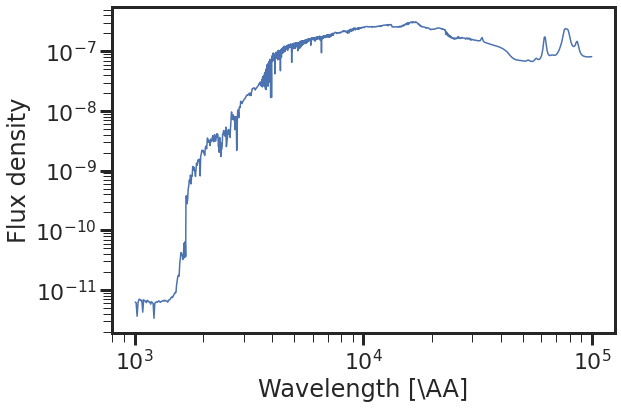

In [ ]:
mstar = 1e8 # in units of solar masses
tage = 1.0 # in Gyr [lookback time, t=0 is the present]
met = 0.0 # in units of log10 solar metallicity, 0.0 is solar, -1.0 is one-tenth solar
dust = 0.2 # A_V units in mags

sp.params['dust2'] = dust
sp.params['logzsol'] = met
lam, spec = sp.get_spectrum(tage = tage)
spec_mass = spec * mstar

plt.figure(figsize=(9,6))
make_spec_plot(lam, spec_mass)

In [ ]:
def make_SSP_spectrum(theta):
    """
    Wrapper function to generate SSP spectrum corresponding to a given set of input parameters
    """

    mstar, tage, met, dust = theta

    sp.params['dust2'] = dust
    sp.params['logzsol'] = met
    lam, spec = sp.get_spectrum(tage = tage)
    spec_mass = spec * mstar
    return spec_mass

Let's compare the spectrum for an old vs young SSP. 

(Keep in mind that we are only working with rest-frame spectra so far in units of luminosity, there's no redshift yet.)

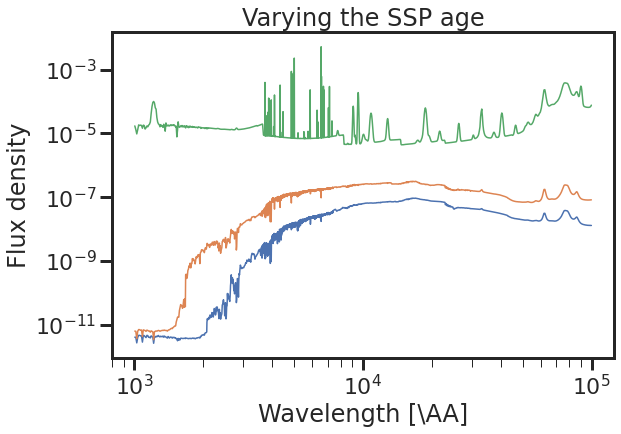

In [ ]:
mstar = 1e8 # in units of solar masses
tage = 10.0 # in Gyr [lookback time, t=0 is the present]
met = 0.0 # in units of log10 solar metallicity, 0.0 is solar, -1.0 is one-tenth solar
dust = 0.2 # A_V units in mags
spec_old = make_SSP_spectrum((mstar, tage, met, dust))

mstar = 1e8 # in units of solar masses
tage = 1.0 # in Gyr [lookback time, t=0 is the present]
met = 0.0 # in units of log10 solar metallicity, 0.0 is solar, -1.0 is one-tenth solar
dust = 0.2 # A_V units in mags
spec_young = make_SSP_spectrum((mstar, tage, met, dust))

mstar = 1e8 # in units of solar masses
tage = 0.001 # in Gyr [lookback time, t=0 is the present]
met = 0.0 # in units of log10 solar metallicity, 0.0 is solar, -1.0 is one-tenth solar
dust = 0.2 # A_V units in mags
spec_very_young = make_SSP_spectrum((mstar, tage, met, dust))

plt.figure(figsize=(9,6))
make_spec_plot(lam, spec_old)
make_spec_plot(lam, spec_young)
make_spec_plot(lam, spec_very_young)
plt.title('Varying the SSP age')
plt.show()

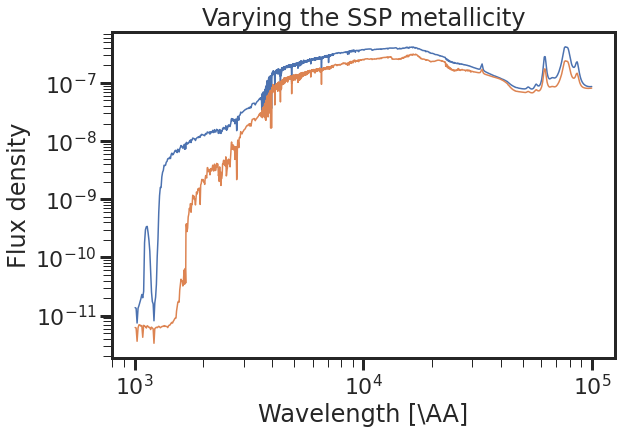

In [ ]:
mstar = 1e8 # in units of solar masses
tage = 1.0 # in Gyr [lookback time, t=0 is the present]
met = -1.0 # in units of log10 solar metallicity, 0.0 is solar, -1.0 is one-tenth solar
dust = 0.2 # A_V units in mags
spec_low_met = make_SSP_spectrum((mstar, tage, met, dust))

mstar = 1e8 # in units of solar masses
tage = 1.0 # in Gyr [lookback time, t=0 is the present]
met = 0.0 # in units of log10 solar metallicity, 0.0 is solar, -1.0 is one-tenth solar
dust = 0.2 # A_V units in mags
spec_high_met = make_SSP_spectrum((mstar, tage, met, dust))

plt.figure(figsize=(9,6))
make_spec_plot(lam, spec_low_met)
make_spec_plot(lam, spec_high_met)
plt.title('Varying the SSP metallicity')
plt.show()

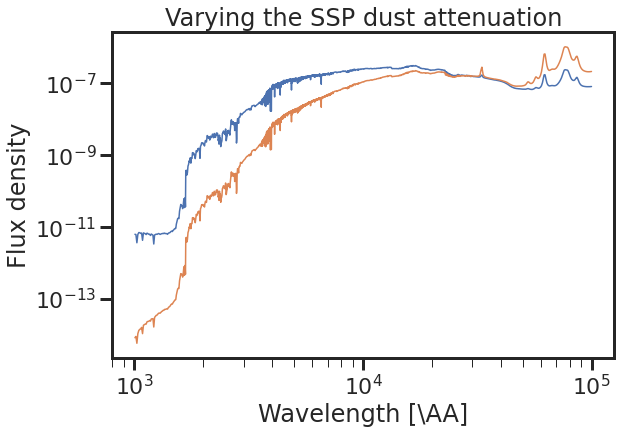

In [ ]:
mstar = 1e8 # in units of solar masses
tage = 1.0 # in Gyr [lookback time, t=0 is the present]
met = 0.0 # in units of log10 solar metallicity, 0.0 is solar, -1.0 is one-tenth solar
dust = 0.2 # A_V units in mags
spec_low_dust = make_SSP_spectrum((mstar, tage, met, dust))

mstar = 1e8 # in units of solar masses
tage = 1.0 # in Gyr [lookback time, t=0 is the present]
met = 0.0 # in units of log10 solar metallicity, 0.0 is solar, -1.0 is one-tenth solar
dust = 2.0 # A_V units in mags
spec_high_dust = make_SSP_spectrum((mstar, tage, met, dust))

plt.figure(figsize=(9,6))
make_spec_plot(lam, spec_low_dust)
make_spec_plot(lam, spec_high_dust)
plt.title('Varying the SSP dust attenuation')
plt.show()

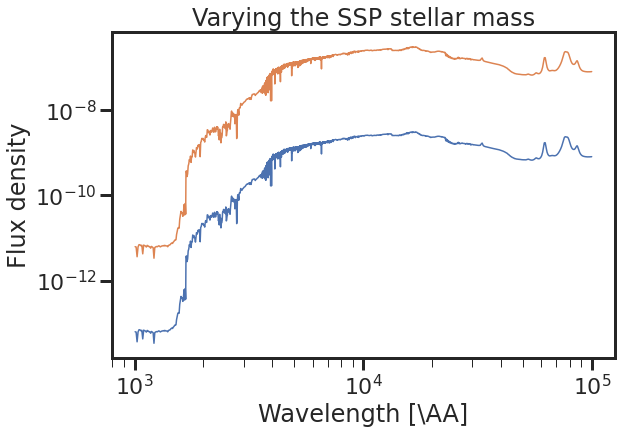

In [ ]:
mstar = 1e6 # in units of solar masses
tage = 1.0 # in Gyr [lookback time, t=0 is the present]
met = 0.0 # in units of log10 solar metallicity, 0.0 is solar, -1.0 is one-tenth solar
dust = 0.2 # A_V units in mags
spec_low_mass = make_SSP_spectrum((mstar, tage, met, dust))

mstar = 1e8 # in units of solar masses
tage = 1.0 # in Gyr [lookback time, t=0 is the present]
met = 0.0 # in units of log10 solar metallicity, 0.0 is solar, -1.0 is one-tenth solar
dust = 0.2 # A_V units in mags
spec_high_mass = make_SSP_spectrum((mstar, tage, met, dust))

plt.figure(figsize=(9,6))
make_spec_plot(lam, spec_low_mass)
make_spec_plot(lam, spec_high_mass)
plt.title('Varying the SSP stellar mass')
plt.show()

## Composite Stellar Populations (CSPs) and Star Formation Histories

So far, we have assumed that all the stars in our stellar population sprang into existence instantaneously at the same time. Now we relax that assumption and put in a star formation history for the galaxy by changing the `sp.params['sfh']` parameter. 

There's many ways of doing this - the simplest involve assuming constant or exponentially declining SFR over time from a certain starting age. More modern versions include a double power-law or linear-rise followed by exponential decline (linexp).

The newest (or most troublesome) class of SFHs are non-parametric methods, either by binning SFH in time and leaving the SFR free in each bin, or by keeping mass quantiles fixed and leaving the times at which these quantiles were formed free. In today's tutorial we will be using the latter, although you are free to use whatever best suits your science case (and sometimes which code you're using). 

We will instantiate the SFH using the `dense_basis` package, and plot some examples:

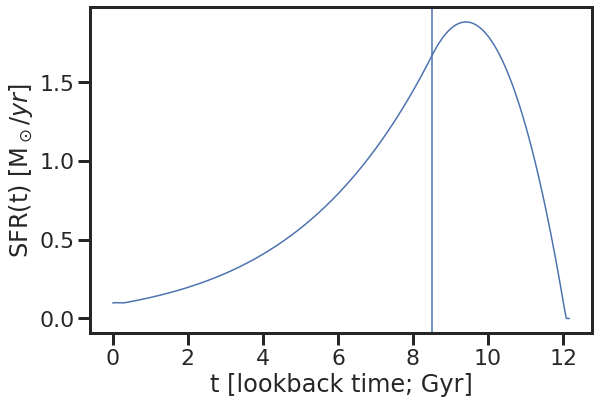

In [ ]:
log_total_mass = 10. # log total mass formed (integral of the SFH)
log_sfr_inst = -1 # log SFR at the time of observation
t50 = 0.3 # fraction of the age of the universe
zval = 0.1 # redshift at which we want to realize this SFH
sfh_tuple = np.array([log_total_mass, log_sfr_inst, 1.0, t50])

sfh, timeax = db.tuple_to_sfh(sfh_tuple, zval)
timeax_lookback = np.amax(timeax) - timeax

plt.figure(figsize=(9,6))
plt.plot(timeax_lookback, sfh)
plt.axvline((1-t50)*np.amax(timeax))
plt.xlabel('t [lookback time; Gyr]')
plt.ylabel('SFR(t) [M$_\odot/yr]$')
plt.show()

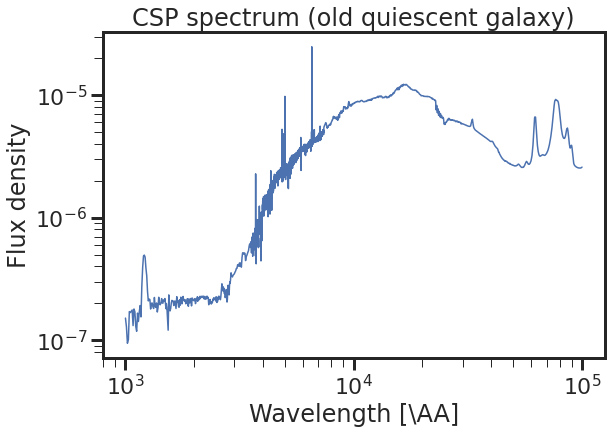

In [ ]:
sp.params['sfh'] = 3 # input a tabular SFH
sp.set_tabular_sfh(timeax, sfh)
lam, spec_csp = sp.get_spectrum(tage=np.amax(timeax))

plt.figure(figsize=(9,6))
make_spec_plot(lam, spec_csp)
plt.title('CSP spectrum (old quiescent galaxy)')
plt.show()

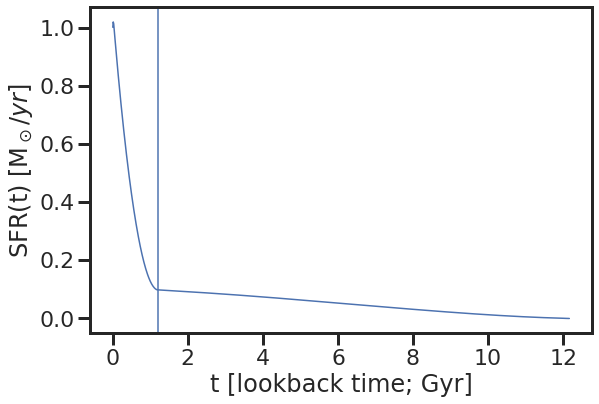

In [ ]:
log_total_mass = 9. # log total mass formed (integral of the SFH)
log_sfr_inst = 0. # log SFR at the time of observation
t50 = 0.9 # fraction of the age of the universe
zval = 0.1 # redshift at which we want to realize this SFH
sfh_tuple = np.array([log_total_mass, log_sfr_inst, 1.0, t50])

sfh, timeax = db.tuple_to_sfh(sfh_tuple, zval)
timeax_lookback = np.amax(timeax) - timeax

plt.figure(figsize=(9,6))
plt.plot(timeax_lookback, sfh)
plt.axvline((1-t50)*np.amax(timeax))
plt.xlabel('t [lookback time; Gyr]')
plt.ylabel('SFR(t) [M$_\odot/yr]$')
plt.show()

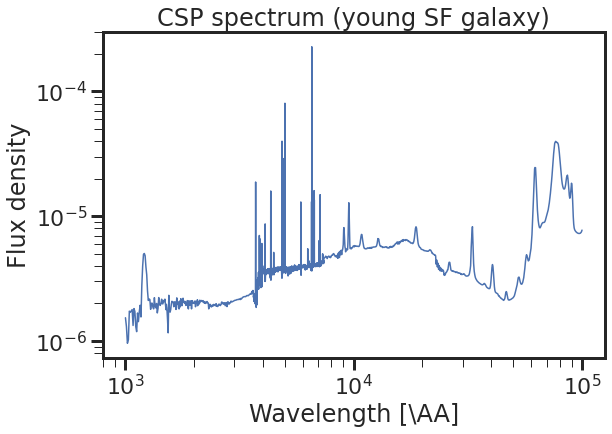

In [ ]:
sp.params['sfh'] = 3 # input a tabular SFH
sp.set_tabular_sfh(timeax, sfh)
lam, spec_csp = sp.get_spectrum(tage=np.amax(timeax))

plt.figure(figsize=(9,6))
make_spec_plot(lam, spec_csp)
plt.title('CSP spectrum (young SF galaxy)')
plt.show()

In [ ]:
def make_CSP_spectrum(theta):
    """
    Wrapper function to generate SSP spectrum corresponding to a given set of input parameters
    """

    log_total_mass, log_sfr_inst, t50, zval, met, dust = theta

    sfh_tuple = np.array([log_total_mass, log_sfr_inst, 1.0, t50])
    sfh, timeax = db.tuple_to_sfh(sfh_tuple, zval)
    sp.params['sfh'] = 3 # input a tabular SFH
    sp.set_tabular_sfh(timeax, sfh)

    sp.params['dust2'] = dust
    sp.params['logzsol'] = met
    lam, spec_csp = sp.get_spectrum(tage = np.amax(timeax))
    return spec_csp

In [ ]:
# making SFHs, 
# making CSPs
# effects of SFH param variance

## Forward modeling observations - redshifts, units, photometry and spectroscopy

Let's make some photometry!

Loading up a filter set:

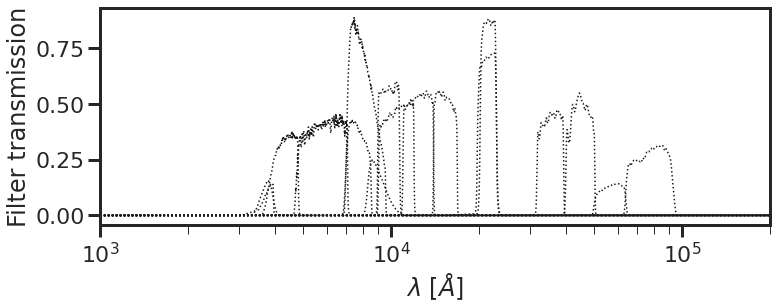

In [ ]:
filter_list = 'filter_list_goodss.dat'
filt_dir = 'internal' # path to directory containing filter list
db.plot_filterset(filter_list = filter_list, filt_dir = filt_dir)

Note: All the plots so far have been in rest-frame spectra, now we switch to the observed frame!

$\lambda → \lambda \times (1+z)$

$L_\nu → F_\nu(z)$ ($\propto (1+z)L_\odot/4 \pi d_L^2$)


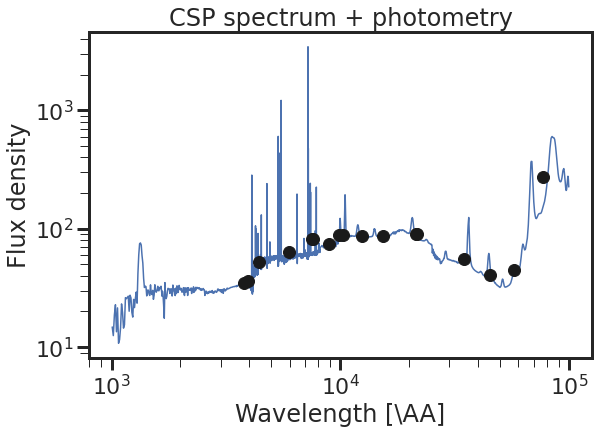

In [ ]:
log_total_mass = 9. # log total mass formed (integral of the SFH)
log_sfr_inst = 0. # log SFR at the time of observation
t50 = 0.9 # fraction of the age of the universe
zval = 0.1 # redshift at which we want to realize this SFH
met = 0.0
dust = 0.2
theta = (log_total_mass, log_sfr_inst, t50, zval, met, dust)

# generate the spectrum for a model galaxy
spec_csp = make_CSP_spectrum(theta)
spec_csp_ujy = db.convert_to_microjansky(spec_csp, zval, db.cosmo)

# multiply spectrum by filter list to get the photometric SED
filcurves, _, _ = db.make_filvalkit_simple(lam, zval, fkit_name = filter_list, filt_dir = filt_dir)
sed_csp_ujy = db.calc_fnu_sed_fast(spec_csp_ujy, filcurves)

# let's plot the galaxy, with one quick extra step - 
# estimating the effective wavelength for each filter
lam_eff = []
for i in range(filcurves.shape[1]):
    lam_eff.append(lam[np.argmin(np.abs(np.cumsum(filcurves[0:,i])/np.amax(np.cumsum(filcurves[0:,i])) - 0.5))])
lam_eff = np.array(lam_eff)

plt.figure(figsize=(9,6))
make_spec_plot(lam*(1+zval), spec_csp_ujy)
plt.plot(lam_eff*(1+zval), sed_csp_ujy,'ko',markersize=12)
plt.title('CSP spectrum + photometry')
plt.show()

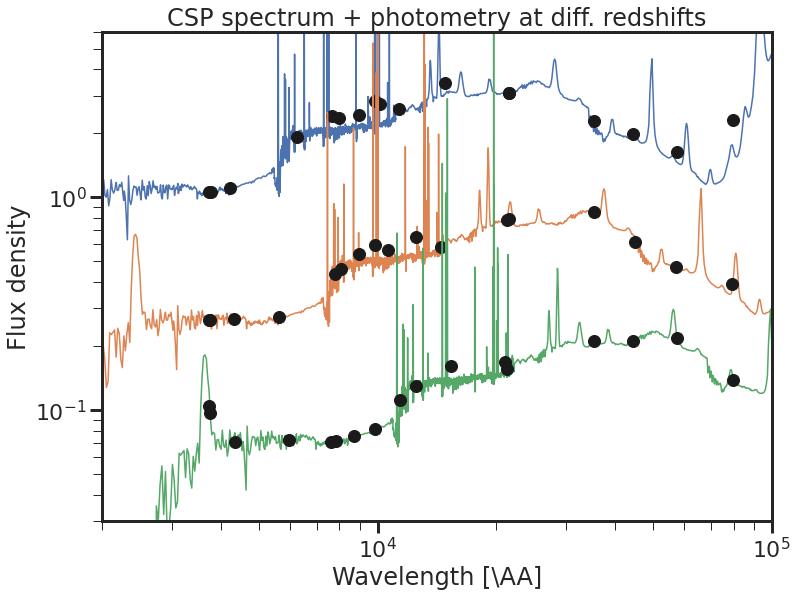

In [ ]:
log_total_mass = 9. # log total mass formed (integral of the SFH)
log_sfr_inst = 0. # log SFR at the time of observation
t50 = 0.9 # fraction of the age of the universe
zval = 0.1 # redshift at which we want to realize this SFH
met = 0.0
dust = 0.2
theta = (log_total_mass, log_sfr_inst, t50, zval, met, dust)

    # generate the spectrum for a model galaxy
spec_csp = make_CSP_spectrum(theta)

# The same SED at different redshifts
zvals = [0.5,1.0,2.0]
plt.figure(figsize=(12,9))

for zval in zvals: 

    spec_csp_ujy = db.convert_to_microjansky(spec_csp, zval, db.cosmo)

    # multiply spectrum by filter list to get the photometric SED
    filcurves, _, _ = db.make_filvalkit_simple(lam, zval, fkit_name = filter_list, filt_dir = filt_dir)
    sed_csp_ujy = db.calc_fnu_sed_fast(spec_csp_ujy, filcurves)

    # let's plot the galaxy, with one quick extra step - 
    # estimating the effective wavelength for each filter
    lam_eff = []
    for i in range(filcurves.shape[1]):
        lam_eff.append(lam[np.argmin(np.abs(np.cumsum(filcurves[0:,i])/np.amax(np.cumsum(filcurves[0:,i])) - 0.5))])
    lam_eff = np.array(lam_eff)


    make_spec_plot(lam*(1+zval), spec_csp_ujy)
    plt.plot(lam_eff*(1+zval), sed_csp_ujy,'ko',markersize=12)
plt.ylim(3e-2,0.6e1); plt.xlim(2e3,1e5)
plt.title('CSP spectrum + photometry at diff. redshifts')
plt.show()

Units:

You might get your hands on SEDs in a variety of units, make sure you're converting to the right ones that your code needs:
- $F_\nu$ [Jansky ($10^{-23}$erg.s$^{-1}$.cm$^{-2}$.Hz$^{-1}$), $\mu$Jy, nJy ...]
- $F_\lambda$ [$F_\nu  (c/\lambda^2)$, erg.s$^{-1}$.cm$^{-2}$.$\mathring A^{-1}$]
- $\nu F_\nu = \lambda F_\lambda$ [$e.s^{-1}$, erg.s$^{-1}$.cm$^{-2}$]
- AB & other magnitudes [$S_\nu (\mu Jy) = 10^6.10^{23}.10^{(-AB+48.6)/2.5})$]
- maggies [$F_\nu [Jy]$/3631, $10^{-2m_{AB}/5}$]

$$F_\nu [Jy] = 3.34(10^4) (\lambda/\mathring A)^2 F_\lambda [erg.s^{-1}.cm^{-2}.A^{-1}]$$

more here: [SDSS flux & magnitude note](https://www.sdss3.org/dr8/algorithms/magnitudes.php)


In [ ]:
# redshifting a spectrum
# units - F_nu and F_lambda, converting between them
# multiplying by filter curves to get photometry
# something about spectra?

Stretch goal: the age-dust-metallicity degeneracy & likelihood spaces.

# 2. Fitting a simple model to data

Before we jump into actual data, let's make a simple mock photometric model that we fit. We can use the `sed_csp_ujy` from the previous section for this purpose. 

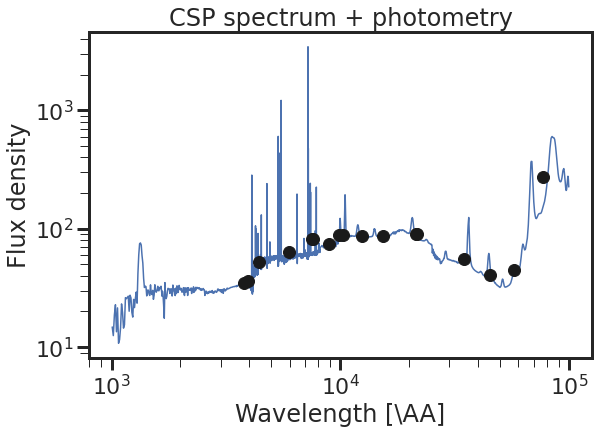

In [ ]:
log_total_mass = 9. # log total mass formed (integral of the SFH)
log_sfr_inst = 0. # log SFR at the time of observation
t50 = 0.9 # fraction of the age of the universe
zval = 0.1 # redshift at which we want to realize this SFH
met = 0.0 # in units of log10 solar metallicity, 0.0 is solar, -1.0 is one-tenth solar
dust = 0.2 # A_V units in mags
true_theta = (log_total_mass, log_sfr_inst, t50, zval, met, dust)

# generate the spectrum for a model galaxy
spec_csp = make_CSP_spectrum(true_theta)
spec_csp_ujy = db.convert_to_microjansky(spec_csp, zval, db.cosmo)

# multiply spectrum by filter list to get the photometric SED
filcurves, _, _ = db.make_filvalkit_simple(lam, zval, fkit_name = filter_list, filt_dir = filt_dir)
sed_csp_ujy = db.calc_fnu_sed_fast(spec_csp_ujy, filcurves)

# let's plot the galaxy, with one quick extra step - 
# estimating the effective wavelength for each filter
lam_eff = []
for i in range(filcurves.shape[1]):
    lam_eff.append(lam[np.argmin(np.abs(np.cumsum(filcurves[0:,i])/np.amax(np.cumsum(filcurves[0:,i])) - 0.5))])
lam_eff = np.array(lam_eff)

plt.figure(figsize=(9,6))
make_spec_plot(lam*(1+zval), spec_csp_ujy)
plt.plot(lam_eff*(1+zval), sed_csp_ujy,'ko',markersize=12)
plt.title('CSP spectrum + photometry')
plt.show()

In [ ]:
from scipy.optimize import minimize

In [ ]:
def chi2_sed(sed, sed_err, sed_model):
    return np.nansum((sed_model-sed)**2 / (sed_err)**2)

def nll(sed, sed_err, sed_model):
    return 0.5*chi2_sed(sed, sed_err, sed_model)

def minloss(theta, sed, sed_err):
    zval = theta[3]
    filcurves, _, _ = db.make_filvalkit_simple(lam, zval, fkit_name = filter_list, filt_dir = filt_dir)
    sed_model = db.calc_fnu_sed_fast(db.convert_to_microjansky(make_CSP_spectrum(theta), zval, db.cosmo), filcurves)
    return nll(sed, sed_err, sed_model)

In [ ]:
SNR = 10
print(minloss(true_theta, sed_csp_ujy, sed_csp_ujy/SNR))

np.random.seed(5)
init_theta = true_theta+np.random.normal(size=6)*0.1
# print(init_theta)
# print(minloss(init_theta, sed_csp_ujy, sed_csp_ujy/SNR))

0.0


In [ ]:
res = minimize(minloss, 
               x0 = init_theta, 
               args=(sed_csp_ujy, sed_csp_ujy/SNR),
               bounds=((8,10),(-1,1),(0.5,0.99),(0.05,0.15),(-0.5,0.5),(0.,1.0)),
               method='BFGS', 
               options={'gtol': 0.9, 'disp': True})
# res

         Current function value: 0.429357
         Iterations: 99
         Function evaluations: 1524
         Gradient evaluations: 216


In [ ]:
print('logM* logSFR t50 z Z Av')
print(['%.2f' %true_theta[i] for i in range(len(true_theta))])
print(['%.2f' %res.x[i] for i in range(len(true_theta))])

logM* logSFR t50 z Z Av
['9.00', '0.00', '0.90', '0.10', '0.00', '0.20']
['9.03', '0.12', '1.00', '0.10', '0.04', '0.19']


Discussion point - can we rewrite this as 
- a grid
- with MCMC
- with nested sampling
- a bayesian NN
- a GP regressor
- anything better/faster?


In [ ]:
# as an MCMC

def lnlike(theta, sed, sed_err):
    zval = theta[3]
    filcurves, _, _ = db.make_filvalkit_simple(lam, zval, fkit_name = filter_list, filt_dir = filt_dir)
    sed_model = db.calc_fnu_sed_fast(db.convert_to_microjansky(make_CSP_spectrum(theta), zval, db.cosmo), filcurves)
    return - 0.5 * chi2_sed(sed, sed_err, sed_model)

def lnprior(theta):
    bounds=((8,10),(-1,1),(0.5,0.99),(0.05,0.15),(-0.5,0.5),(0.,1.0))
    priorval = 0.0
    for i in range(len(theta)):
        if (theta[i] < bounds[i][0]) or (theta[i] > bounds[i][1]):
            return -np.inf
    return 0.0

def lnprob(theta, sed, sed_err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, sed, sed_err)

In [ ]:
ndim, nwalkers = 6, 20
temp = res["x"]
temp[2] = 0.9
pos = [temp + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [ ]:
import emcee

SNR = 30

filename = "sed_tutorial.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with db.MultiPool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(sed_csp_ujy, sed_csp_ujy/SNR), backend=backend, pool = pool)
    sampler_out = sampler.run_mcmc(pos, 100, progress=True)

100%|██████████| 100/100 [13:22<00:00,  8.03s/it]


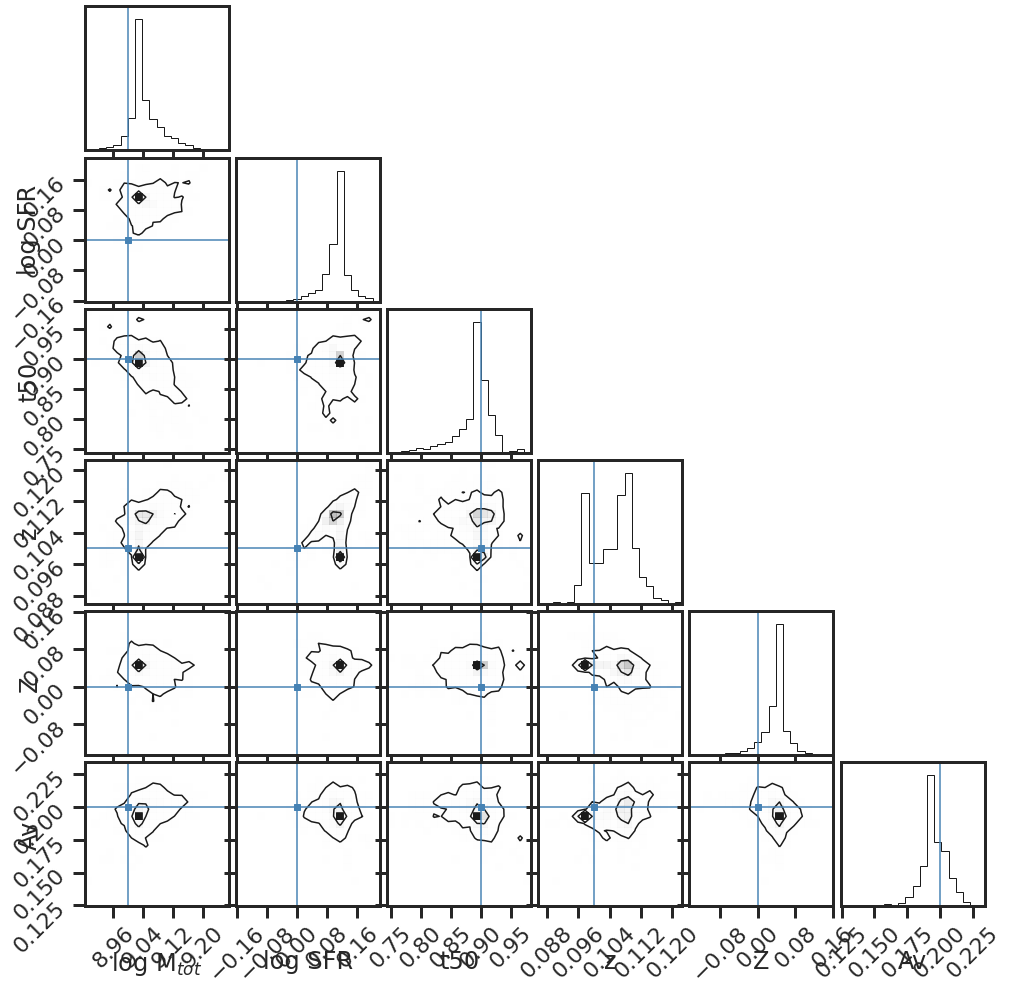

In [ ]:
import corner

samples = sampler.get_chain(flat=True).reshape((-1, ndim))

labels = ['log M$_{tot}$','log SFR','t50','z','Z','Av']
fig = corner.corner(samples,
                    truths=true_theta,
                    labels=labels,
                    levels=[1 - np.exp(-(1/1)**2/2),1 - np.exp(-(2/1)**2/2)], #quantiles=(0.16,0.84), 
                    plot_datapoints=False)
plt.show()

Run with 100 walksers and ~5k steps (allowing the MCMC to converge), yields a much more sensible posterior (see below)

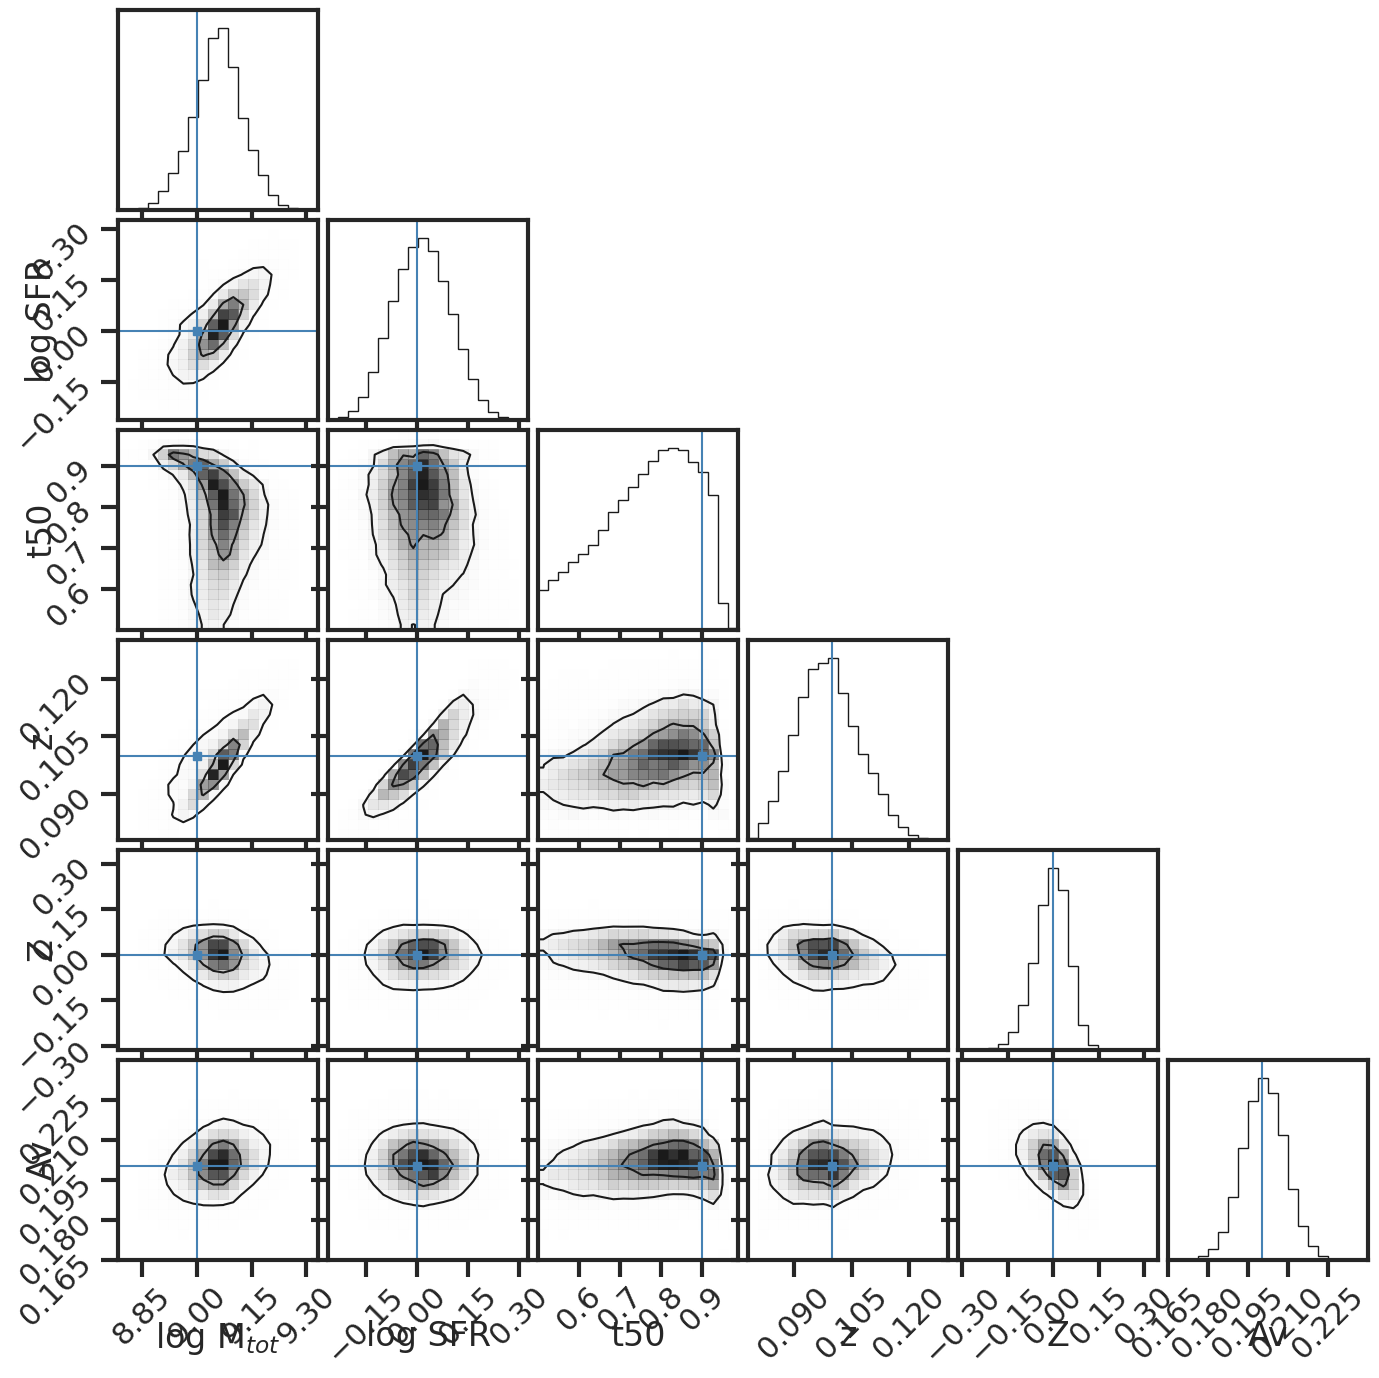

# 3. Fitting considerations: SNR & Wavelength coverage

## Step 1: Set up the experiment and load in a precomputed atlas

Since we are running this experiment and want to fit a bunch of SEDs under different conditions, we need a setup that allows us to approximately estimate physical parameters in a short amount of time. (*Note:* For more thorough fitting, see Adam's talks on using the nested sampling framework in `Bagpipes`, or re-run this experiment with a larger framework or the `emcee` module in `dense basis`. For a comparison of different sampling techniques, see this [colab notebook](https://drive.google.com/file/d/1GS4aVc7jel5EjNdlQdHaHEASNZoVjG3v/view?usp=sharing) for the unconference session on Thursday.)

What we are doing here is called 'brute-force Bayesian' parameter estimation (e.g. in Pacifici et al. 12, 16) or 'random densely-sampling of parameter space' (RDSPS; Abdurro'uf et al. 2021). Basically, we create an atlas by sampling from the prior distributions for each parameter being fit (these can be defined analytically, or derived from a simulation etc.). This atlas then provides a mapping from parameter to SED (observable) space:

$$ \mathrm{parameters} ~(M_*, \mathrm{SFR}, ...) \leftrightarrow \mathrm{SEDs}~ (F_\nu (\lambda), \mathrm{counts}...) $$

We can then evaluate the likelihood of each set of model parameters by comparing the model SED to the observations. Using this set of prior-weighted likelihoods, we then compute the posterior parameter estimates and covariances. 

The pre-computing of the atlas needs to be done only once before fitting a sed of observations, and in this example, we use a premade atlas that can be downloaded below. In general, the `dense basis` code allows for the computation of an atlas using a set of prior parameter distributions of a user-specified size.

In [ ]:
# List of filters transmission curves. 
# For this exercise, we'll be using the set of 17 photometric filters 
# corresponding to galaxies in the CANDELS GOODS-South field. 

filter_list = 'filter_list_goodss.dat'
filt_dir = 'internal' # path to directory containing filter list
#db.plot_filterset(filter_list = filter_list, filt_dir = filt_dir)

priors = db.Priors()
priors.tx_alpha = 3.0
#priors.plot_prior_distributions()

fname = 'test_atlas'
N_pregrid = 100000
priors.Nparam = 3
path = 'atlas/'

# Run the lines of code below if this notebook is used without a precomputed atlas

db.generate_atlas(N_pregrid = 10, # change this to N_pregrid=100000 for the full atlas
                  priors = priors,
                  fname = fname, store=True, path='atlas/',
                  filter_list = filter_list, filt_dir = filt_dir)

generating atlas with: 
3  tx parameters,  sSFRflat  SFR sampling custom  SFH treatment flat  met sampling Calzetti  dust attenuation exp  dust prior False  SFR decoupling.


100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

Path exists. Saved atlas at : atlas/test_atlas_10_Nparam_3.dbatlas


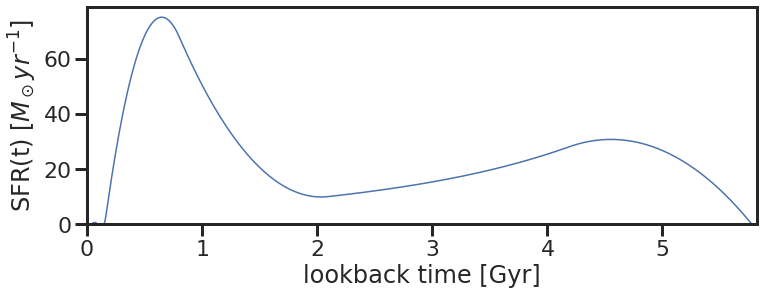

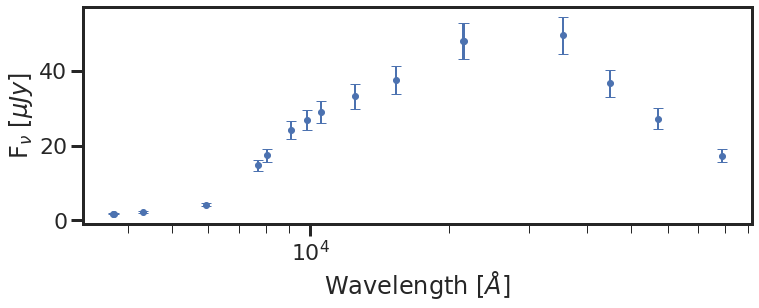

In [ ]:
# sample from the prior space to get parameters
rand_sfh_tuple, rand_Z, rand_Av, rand_z = priors.sample_all_params(random_seed = 1)
specdetails = [rand_sfh_tuple, rand_Av, rand_Z, rand_z]

# generate an SFH corresponding to the SFH-tuple and see how it looks:
rand_sfh, rand_time = db.tuple_to_sfh(rand_sfh_tuple, zval = rand_z)
fig = db.plot_sfh(rand_time, rand_sfh, lookback=True)
sfh_truths = [rand_time, rand_sfh]

# generate a corresponding spectrum and multiply by filter curves to get the SED:
obs_sed = db.makespec(specdetails, priors, db.mocksp, db.cosmo,
                             filter_list=filter_list,filt_dir=filt_dir,input_sfh=False)
full_sed = obs_sed.copy()
obs_err = obs_sed * 0.1 # S/N of 10

# plot the generated SED
centers_goodss = np.array([3734,3722,4317,5918,7693,8047,9055,9851,10550,12486,15370,21605,21463,35508,44960,57245,78840])
plt.figure(figsize=(12,4)); plt.errorbar(centers_goodss, obs_sed, obs_err,lw=0,elinewidth=2,capsize=5,marker='o')
plt.xscale('log'); plt.xlabel('Wavelength [$\AA$]'); plt.ylabel(r'F$_\nu$ [$\mu Jy$]');plt.show()

# store the true stellar mass and SFR
mstar_true = np.log10(db.mocksp.stellar_mass)
sfr_true = np.log10(db.mocksp.sfr)

sed_truths = (mstar_true, sfr_true, rand_sfh_tuple[3:], rand_Z, rand_Av, rand_z)
sed_truths = np.hstack(sed_truths)

In [ ]:
# load the atlas - needs to be done only once
atlas = db.load_atlas(fname, N_pregrid = N_pregrid, N_param = priors.Nparam, path = path)

In [ ]:
# --------------------------------
# Fitting the observed SED
# --------------------------------

# pass the atlas and the observed SED + uncertainties into the fitter,
sedfit = db.SedFit(obs_sed, obs_err, atlas, fit_mask=[])

# evaluate_likelihood returns the likelihood for each SED in the atlas and the norm value to
# best match the observed SED with the atlas.
sedfit.evaluate_likelihood()

# evaluate_posterior_percentiles calculates the 16,50,84th percentiles for
# the physical parameters - stellar mass, SFR, tx, dust, metallicity and redshift
sedfit.evaluate_posterior_percentiles()

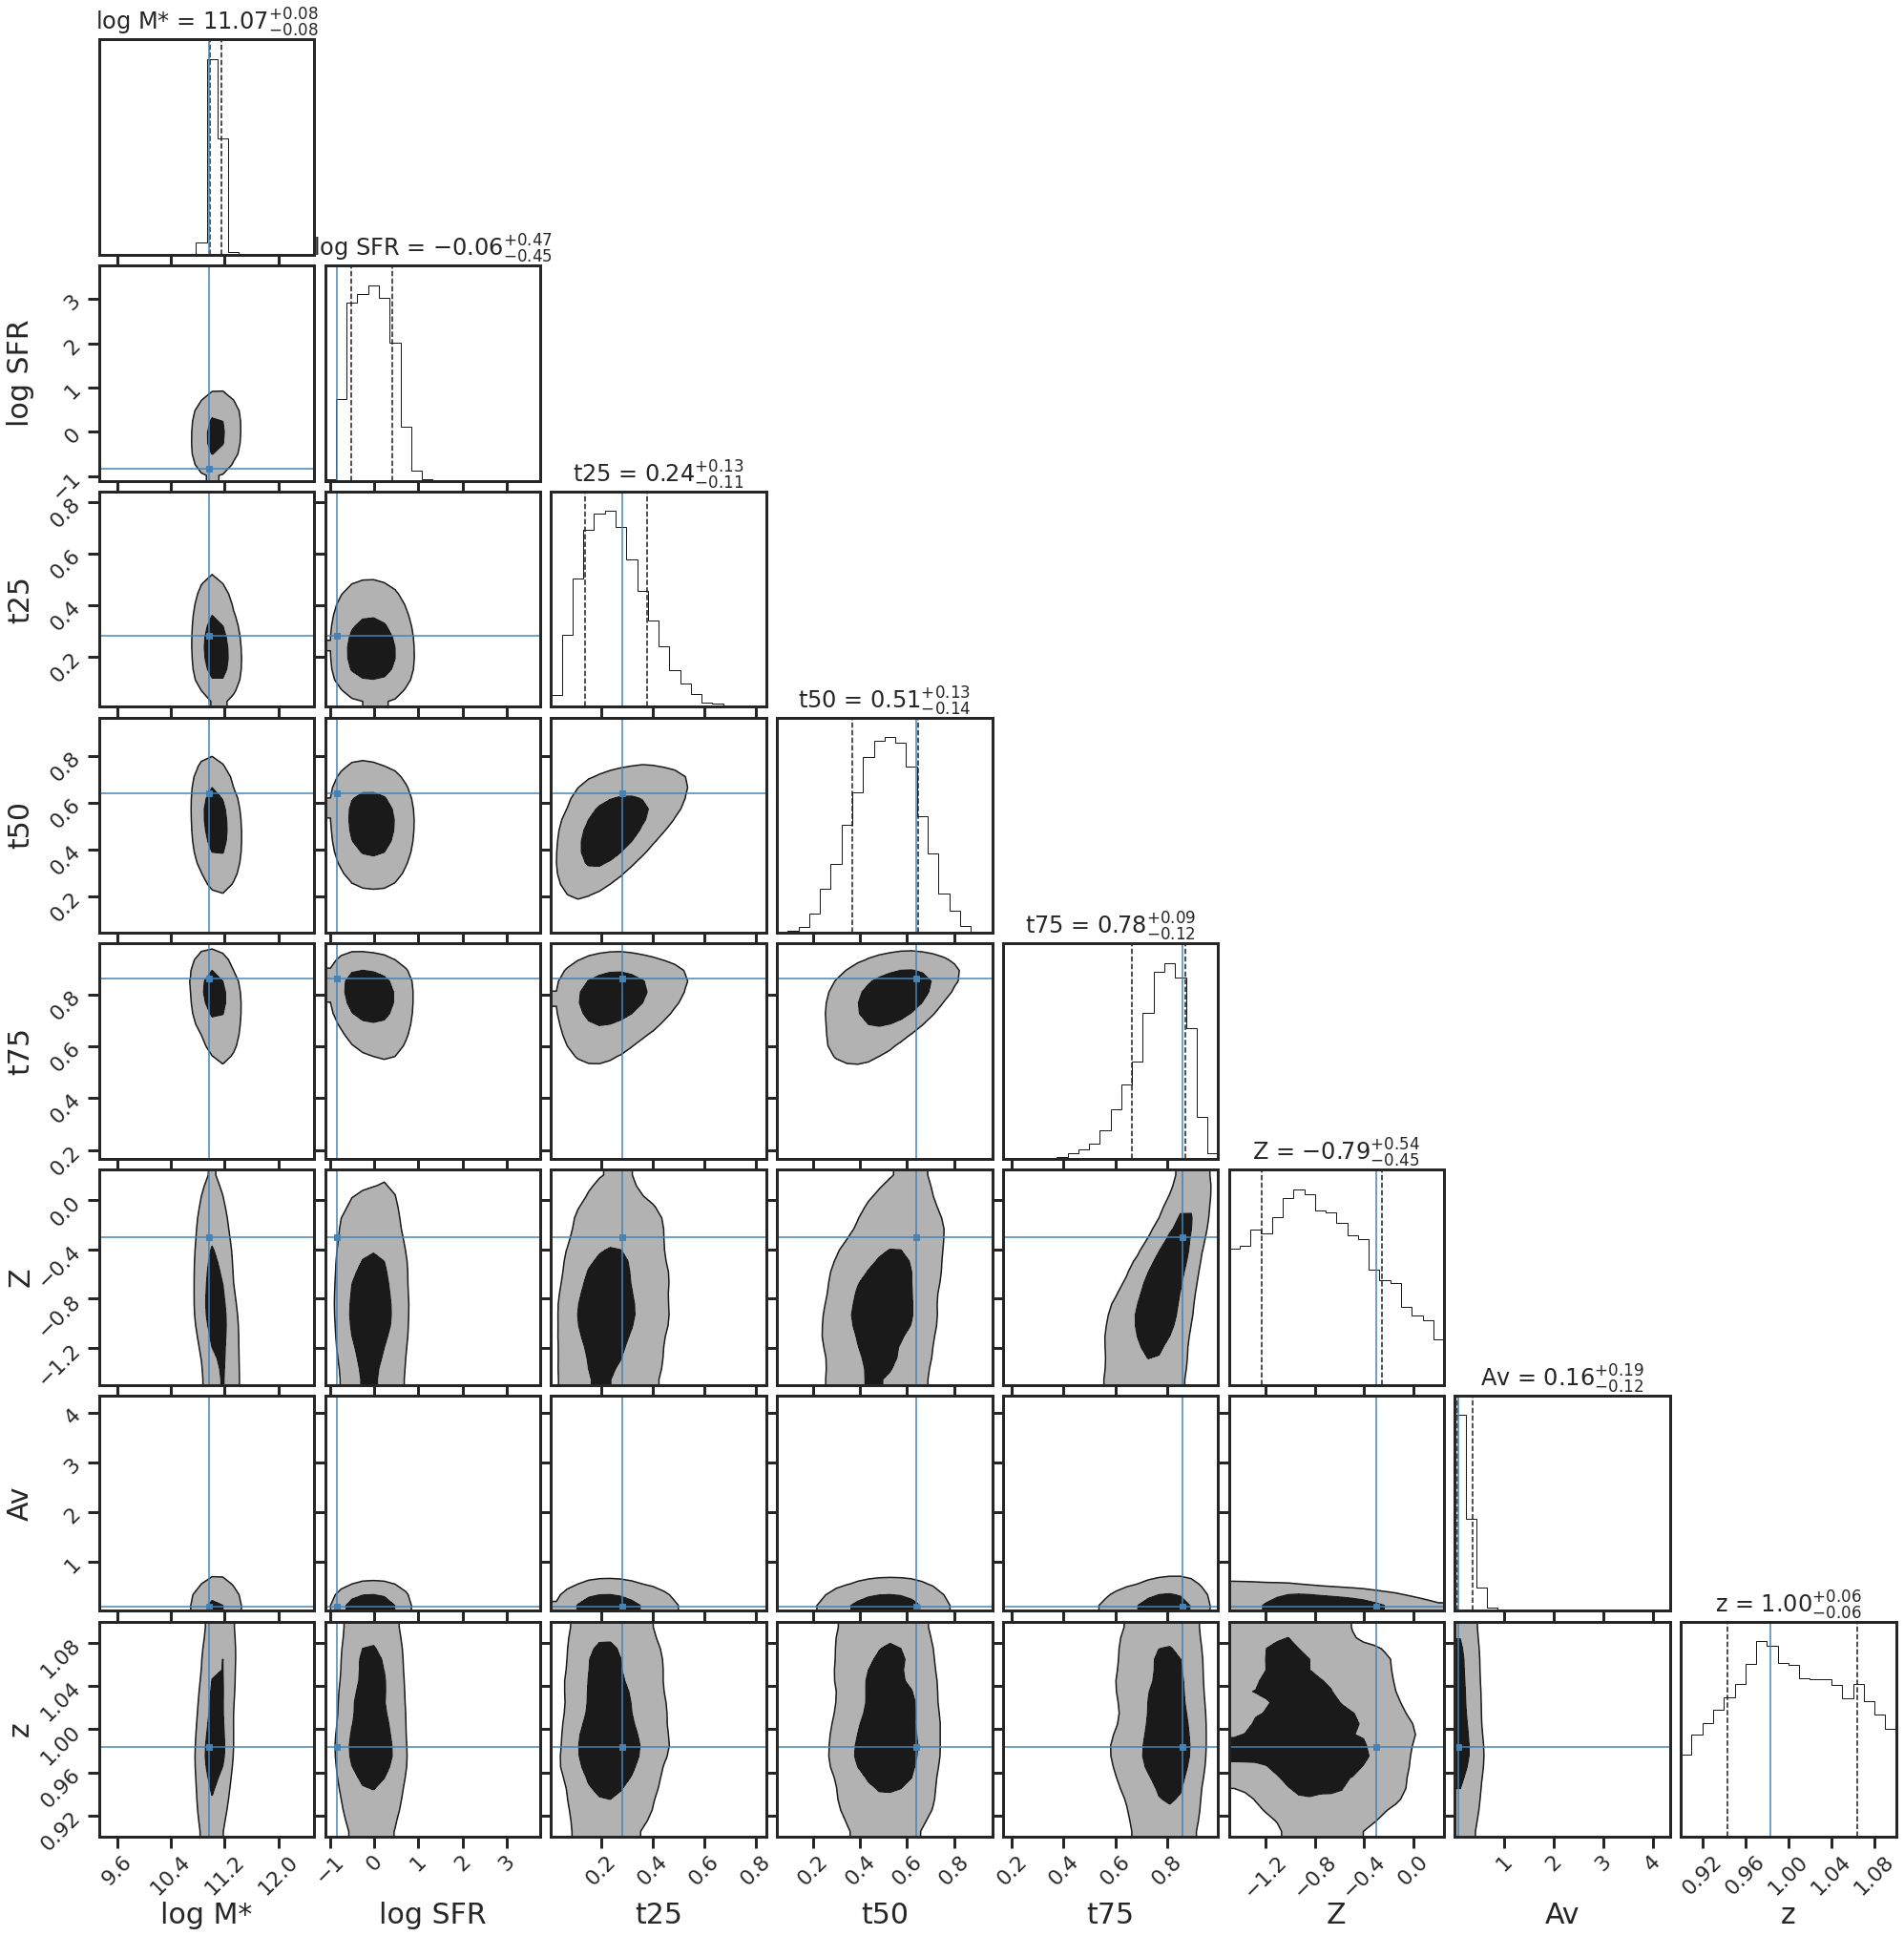

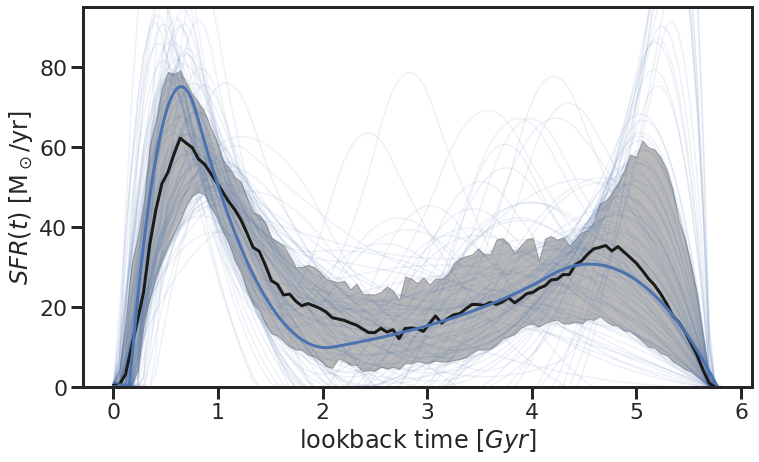

In [ ]:
sedfit.plot_posteriors(truths=sed_truths)
plt.show()

sedfit.plot_posterior_SFH(sedfit.z[0])
plt.plot(np.amax(sfh_truths[0]) - sfh_truths[0],sfh_truths[1],lw=3)
plt.show()

### To check the effects of data quality, let us now check what happens when we vary the SNR of the observations. 

Assuming uncertainties for SNR in the range (1,50), (i.e., with `obs_err = obs_sed / SNR`), fit the same SED and estimate posterior percentiles. Plot these as a function of SNR and quantify how they change as the uncertainties grow smaller and SEDs go from a prior-dominated to likelihood-dominated regime with better SNR. 

In [ ]:
# ---------------------------------------
# ---------- Answer to Q2 ---------------
# ---------------------------------------

#snrvals = [1.,3.,5.,10.,30.,50.,100.]
snrvals = np.arange(1,50,5)

for snr in db.tqdm(snrvals):
    
    #print('running fits at SNR: %.0f' %snr)

    obs_sed = db.makespec(specdetails, priors, db.mocksp, db.cosmo,
                                 filter_list=filter_list,filt_dir=filt_dir,input_sfh=False)
    obs_err = obs_sed / snr

    # pass the atlas and the observed SED + uncertainties into the fitter,
    sedfit = db.SedFit(obs_sed, obs_err, atlas, fit_mask=[])
    sedfit.evaluate_likelihood()
    sedfit.evaluate_posterior_percentiles()
    
    sedfit.plot_posteriors(truths=sed_truths)
    tempy = plt.ylim()
    #print(tempy)
    plt.text(0.42,tempy[1]*7,'SNR: %.0f' %snr, fontsize=50,fontweight='bold')
    #plt.show()
    try:
        plt.savefig('figures/snr_comparison_%.0f.png' %snr,bbox_inches='tight')
    except:
        os.mkdir('figures/')
        plt.savefig('figures/snr_comparison_%.0f.png' %snr,bbox_inches='tight')
    plt.close()

100%|██████████| 10/10 [01:03<00:00,  6.40s/it]


In [ ]:
# save as a .gif to see the evolution
import imageio

images = []
for snr in db.tqdm(snrvals):
    images.append(imageio.imread('figures/snr_comparison_%.0f.png' %snr))
imageio.mimsave('figures/animated_SNR_posteriors.gif', images, format='GIF', fps = 5)


100%|██████████| 10/10 [00:01<00:00,  8.80it/s]


### Changing wavelength coverage

Now let us change which filters we use to fit the SED (assuming we don't have observations in the other fliters) and see how the posteriors change.


In [ ]:
centers_goodss = np.array([3734,3722,4317,5918,7693,8047,9055,9851,10550,12486,15370,21605,21463,35508,44960,57245,78840])
filter_names = ['CTIO_U','VIMOS_U','f435w','f606w','f775w','f814w','f850lp','f098m','f105w','f125w','f160w','ISAAC_Ks','HawkI_Ks','IRAC_ch1','IRAC_ch2','IRAC_ch3','IRAC_ch4']
# snr = 30
blankfilt = np.ones_like(centers_goodss) * False

filtset_uv = blankfilt.copy() # Ground based
filtset_uv[0:2] = True
filtset_uv = filtset_uv.astype(bool)

filtset_acs = blankfilt.copy()
filtset_acs[2:7] = True
filtset_acs = filtset_acs.astype(bool)

filtset_wfc3 = blankfilt.copy()
filtset_wfc3[7:11] = True
filtset_wfc3 = filtset_wfc3.astype(bool)

filtset_ks = blankfilt.copy() # Ground based
filtset_ks[11:13] = True
filtset_ks = filtset_ks.astype(bool)

filtset_irac = blankfilt.copy()
filtset_irac[13:17] = True
filtset_irac = filtset_irac.astype(bool)

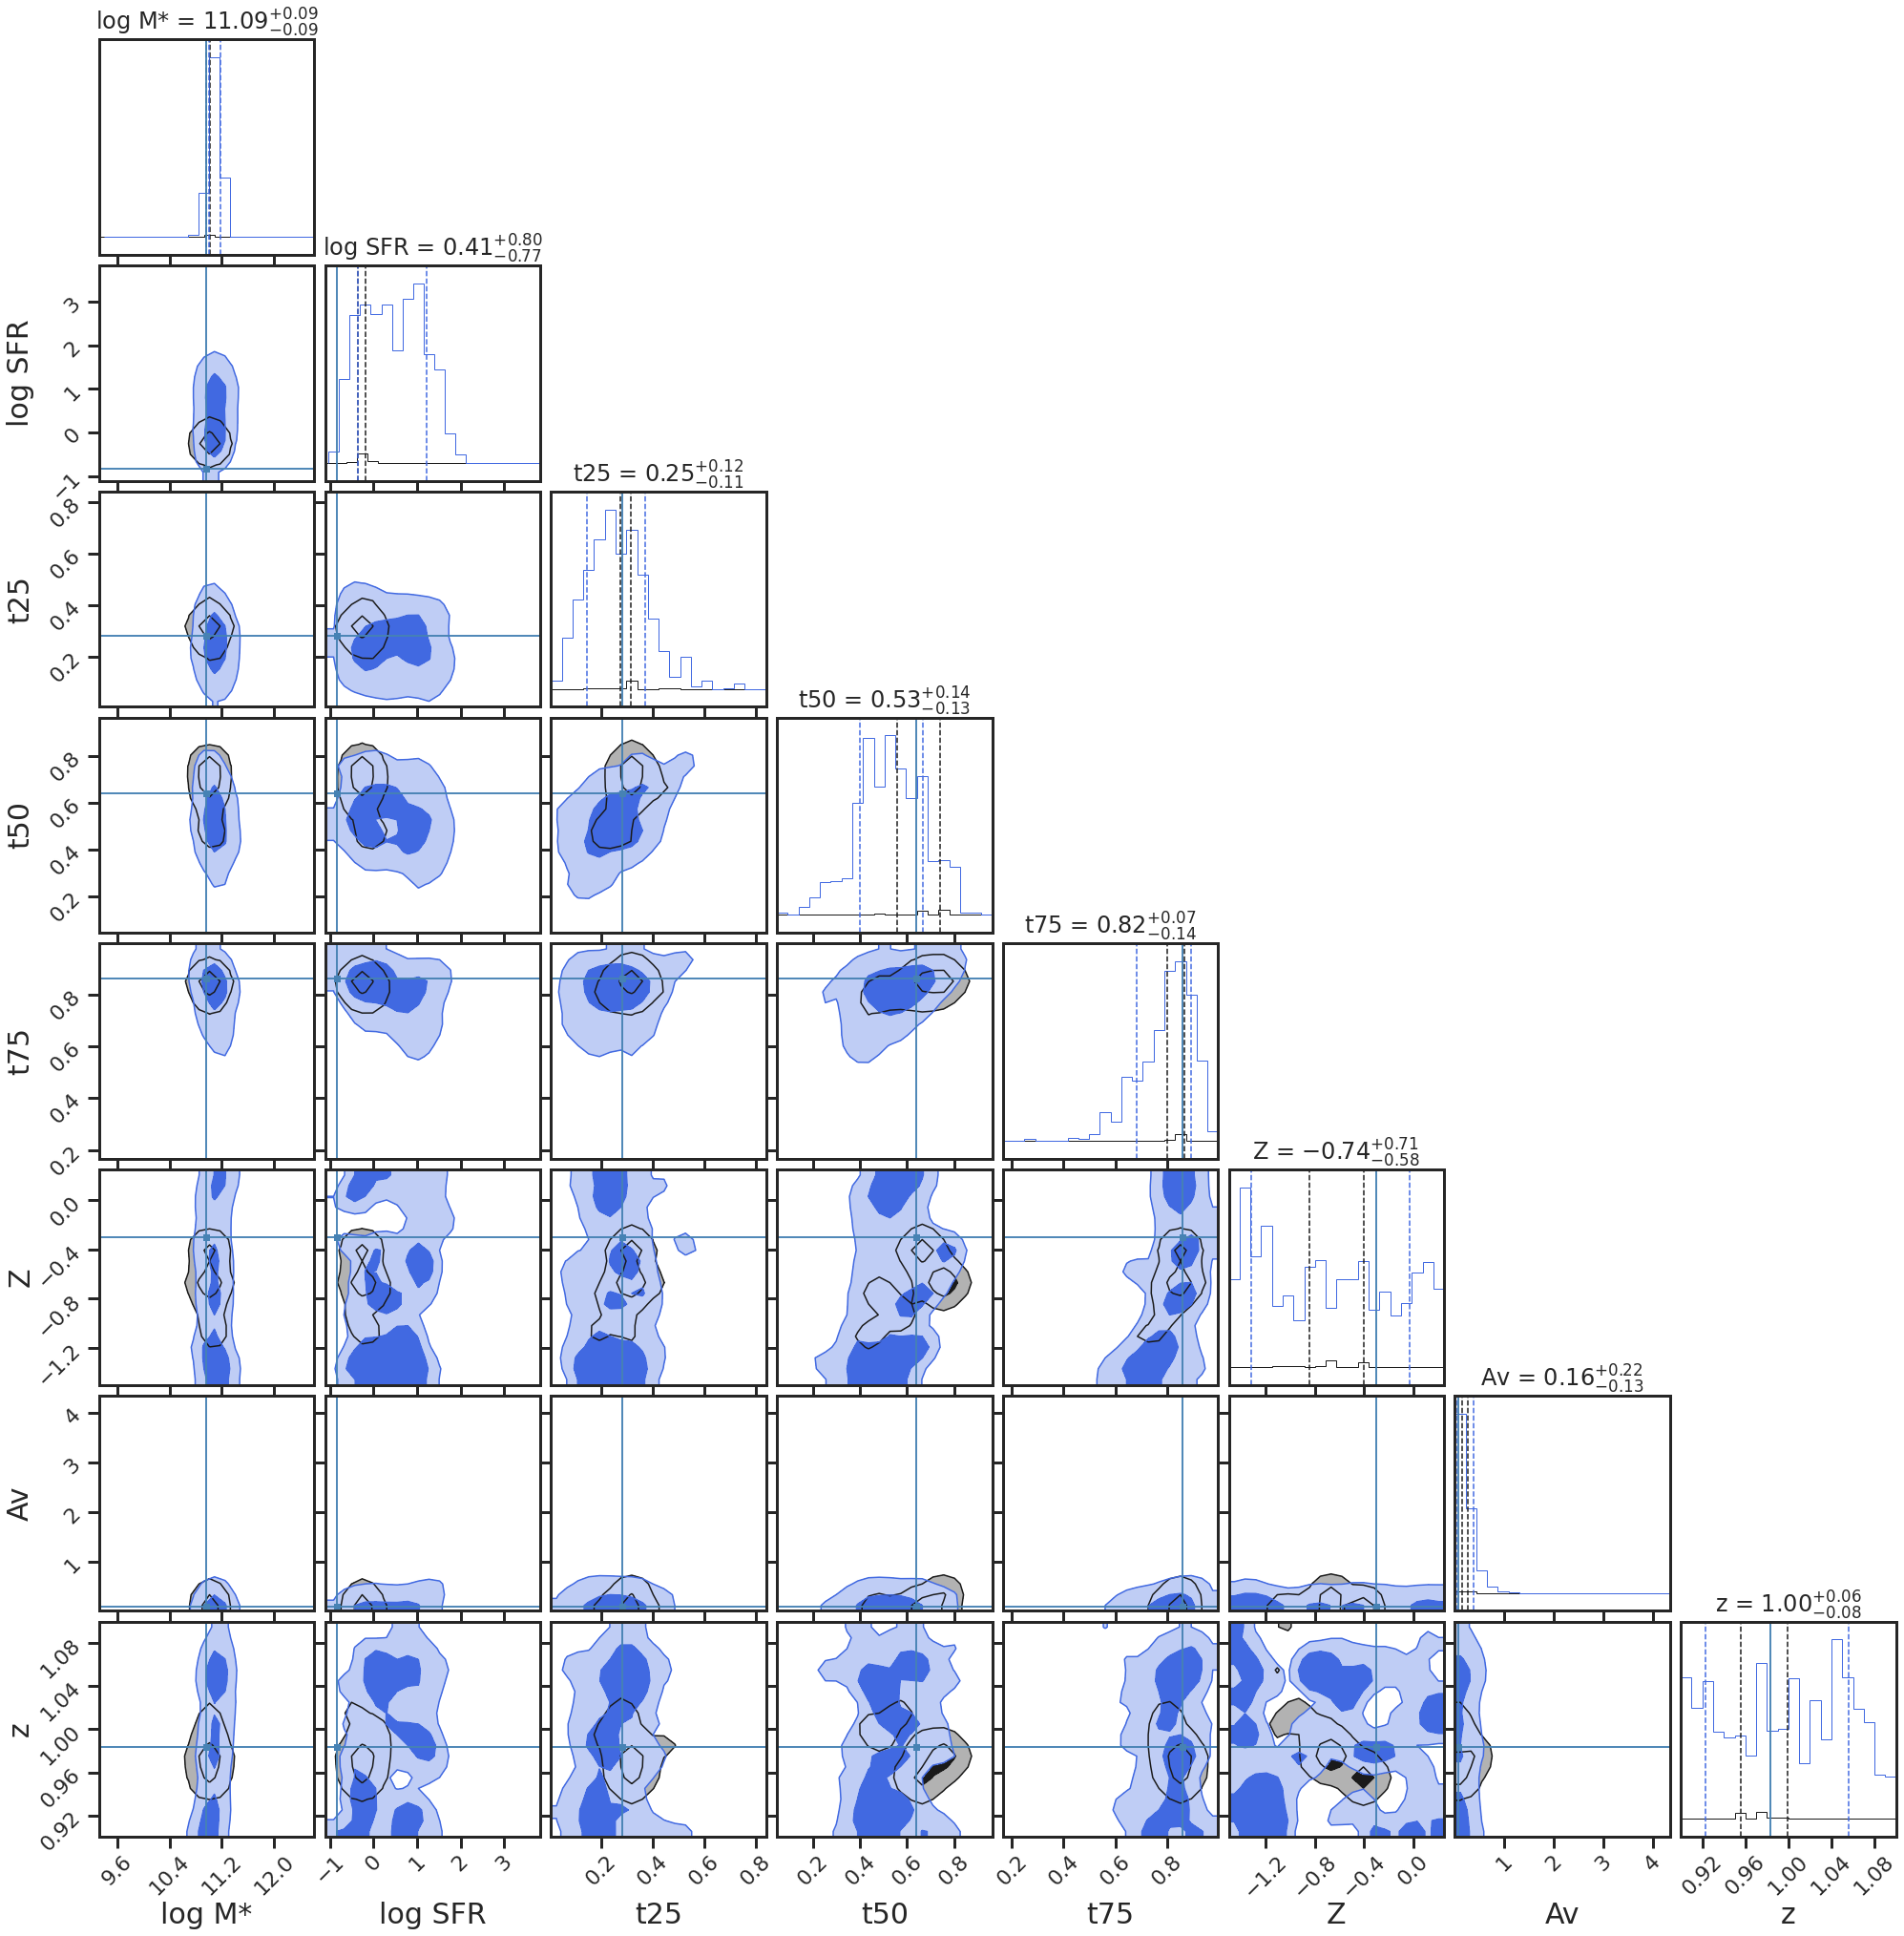

In [ ]:
# For reference, fit the SED with all the bands

fit_mask = []
obs_sed = db.makespec(specdetails, priors, db.mocksp, db.cosmo,
                                filter_list=filter_list,filt_dir=filt_dir,input_sfh=False)
obs_sed[fit_mask == False] = np.nan
obs_err = obs_sed / snr

# pass the atlas and the observed SED + uncertainties into the fitter,
sedfit = db.SedFit(obs_sed, obs_err, atlas, fit_mask=fit_mask)
sedfit.evaluate_likelihood()
sedfit.evaluate_posterior_percentiles()

fig = db.plot_posteriors(sedfit.chi2_array, sedfit.norm_fac, sedfit.sed, sedfit.atlas, truths = sed_truths, scale_hist=True)

#-------------------------------------------------------------

# Now fit the SED using only the observations in the WFC3 filters

fit_mask = filtset_wfc3

obs_sed = db.makespec(specdetails, priors, db.mocksp, db.cosmo,
                                filter_list=filter_list,filt_dir=filt_dir,input_sfh=False)
obs_sed[fit_mask == False] = np.nan
obs_err = obs_sed / snr

# pass the atlas and the observed SED + uncertainties into the fitter,
sedfit = db.SedFit(obs_sed, obs_err, atlas, fit_mask=fit_mask)
sedfit.evaluate_likelihood()
sedfit.evaluate_posterior_percentiles()

fig = db.plot_posteriors(sedfit.chi2_array, sedfit.norm_fac, sedfit.sed, sedfit.atlas, truths = sed_truths, fig = fig, scale_hist=True, color='royalblue')

#-------------------------------------------------------------

# tempy = plt.ylim()
# plt.text(0.42,tempy[1]*7,'# filters: %.0f' %(filti+1), fontsize=50,fontweight='bold')
# plt.savefig('figures/wavcov_comparison_test.png',bbox_inches='tight')
# plt.close()
plt.show()

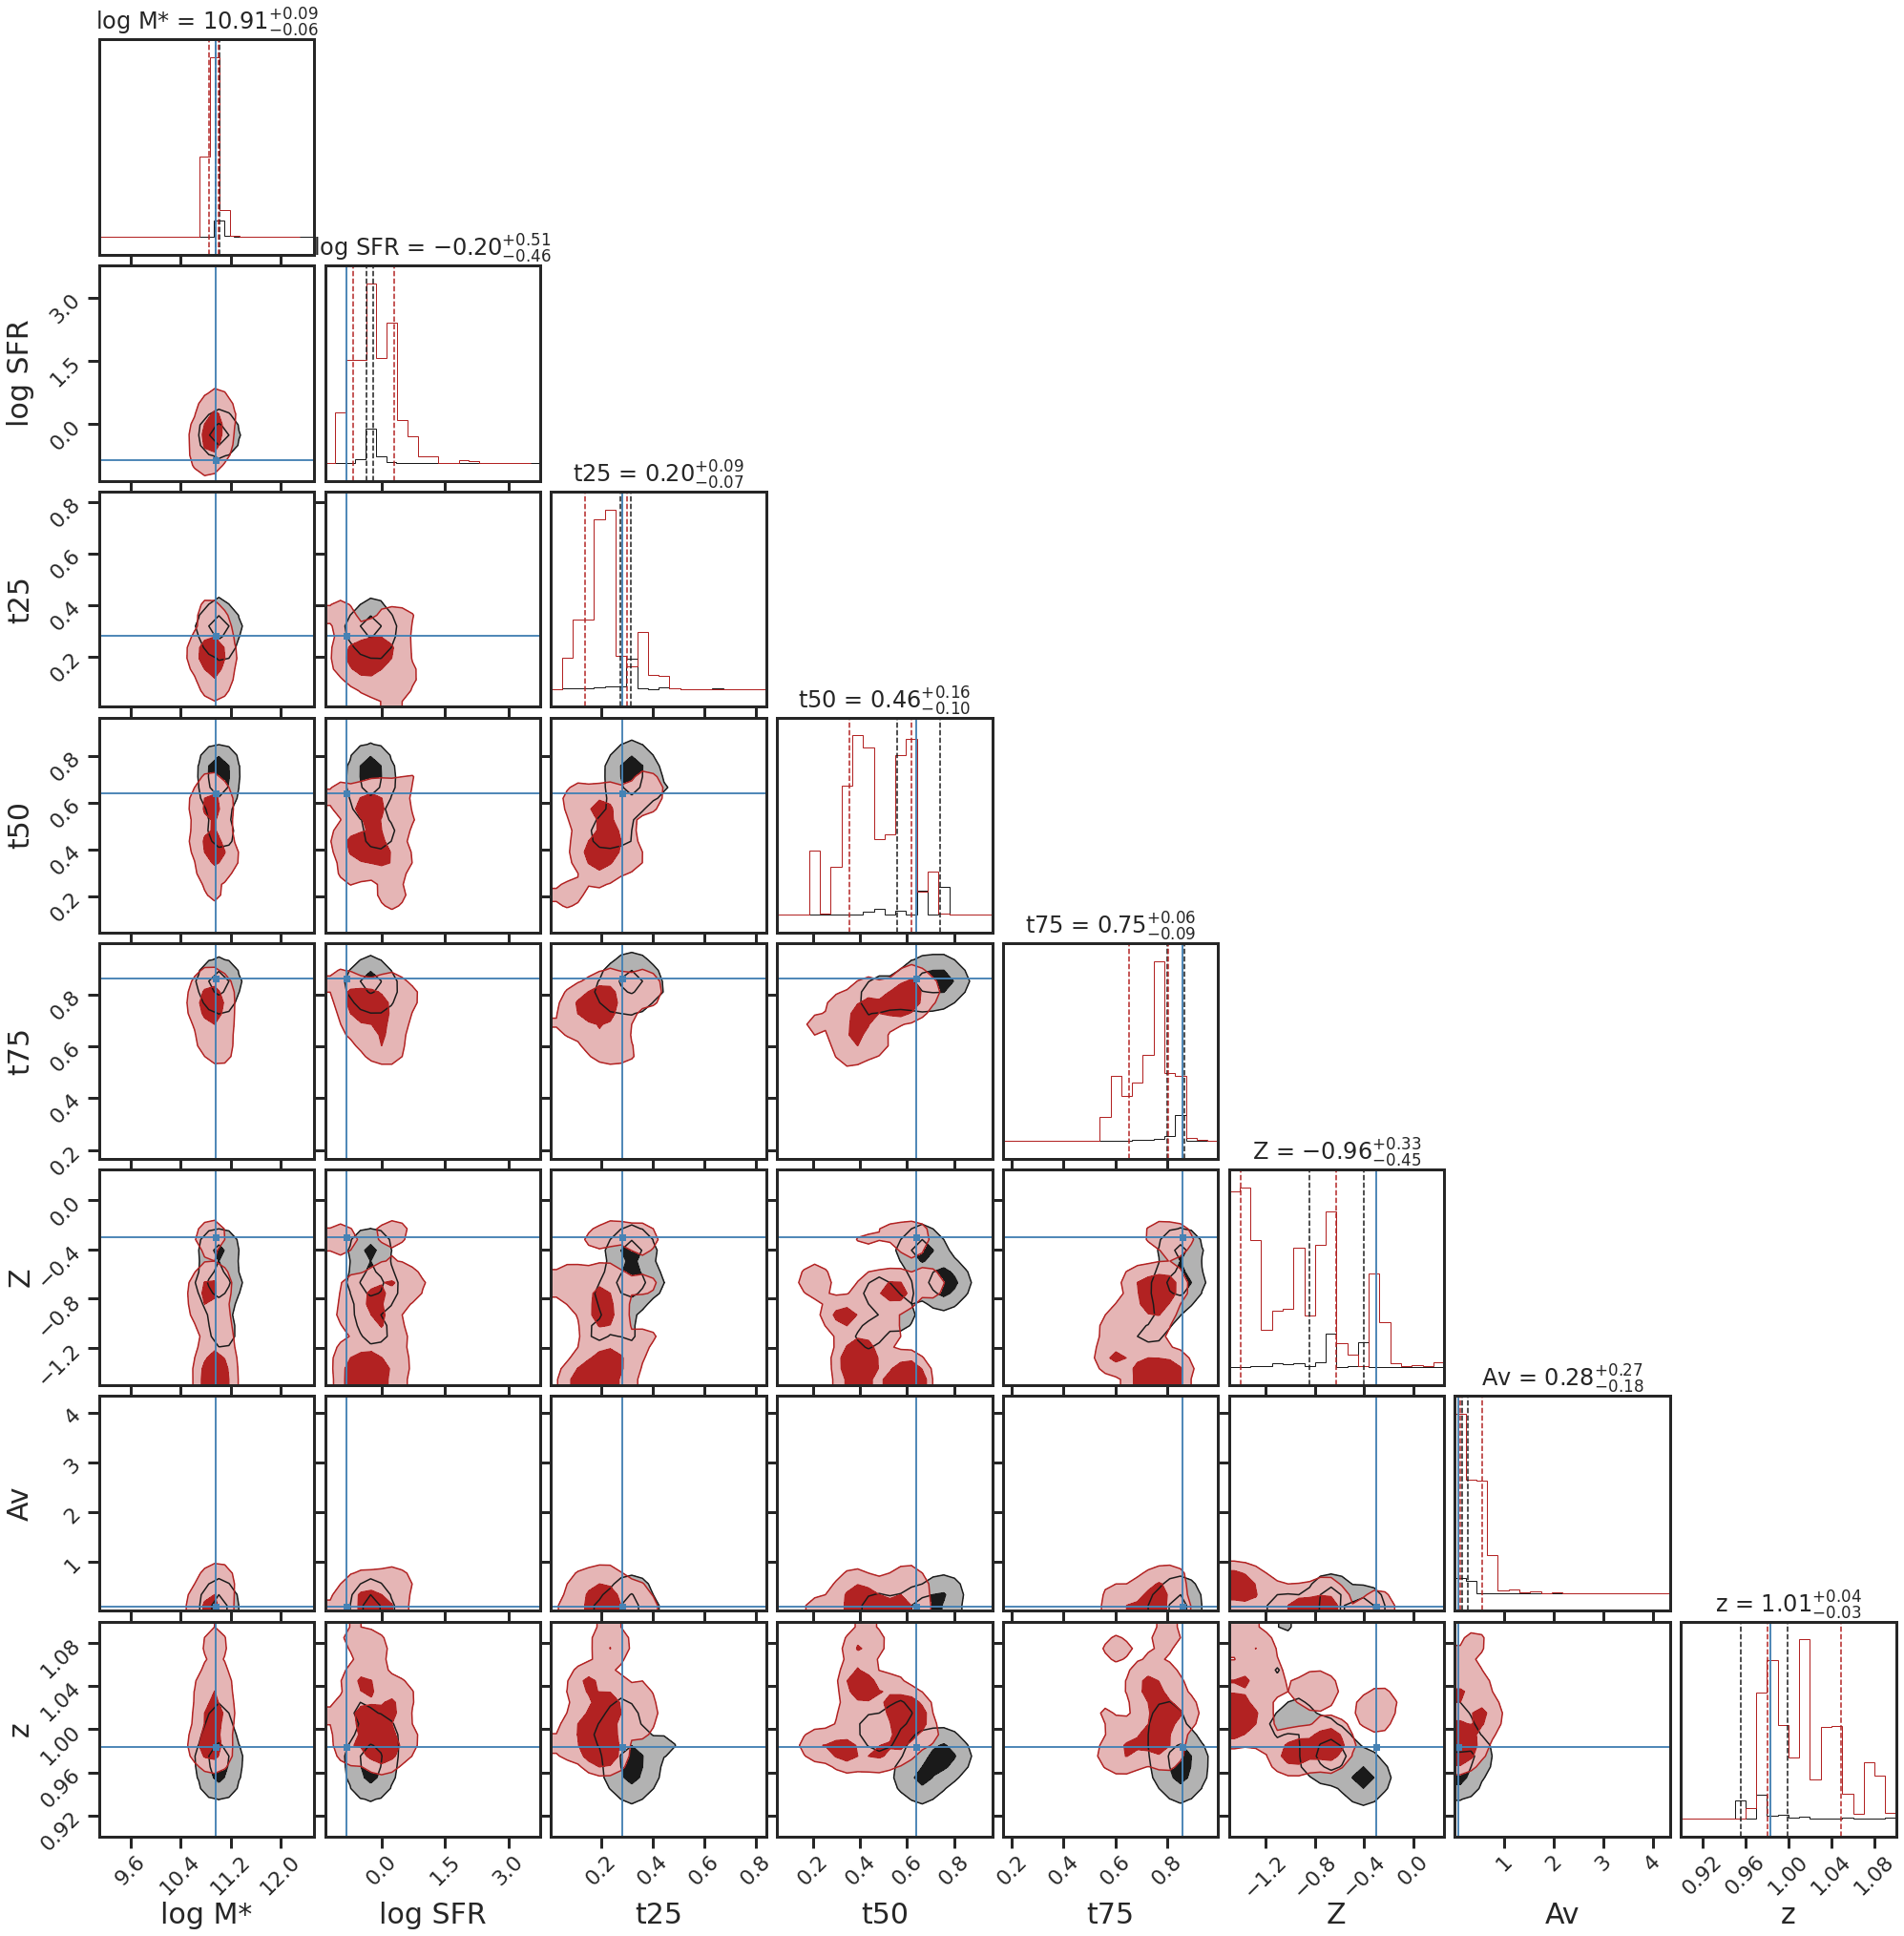

In [ ]:
fit_mask = []
obs_sed = db.makespec(specdetails, priors, db.mocksp, db.cosmo,
                                filter_list=filter_list,filt_dir=filt_dir,input_sfh=False)
obs_sed[fit_mask == False] = np.nan
obs_err = obs_sed / snr

# pass the atlas and the observed SED + uncertainties into the fitter,
sedfit = db.SedFit(obs_sed, obs_err, atlas, fit_mask=fit_mask)
sedfit.evaluate_likelihood()
sedfit.evaluate_posterior_percentiles()

fig = db.plot_posteriors(sedfit.chi2_array, sedfit.norm_fac, sedfit.sed, sedfit.atlas, truths = sed_truths, scale_hist=True)

#-------------------------------------------------------------

fit_mask = filtset_acs

obs_sed = db.makespec(specdetails, priors, db.mocksp, db.cosmo,
                                filter_list=filter_list,filt_dir=filt_dir,input_sfh=False)
obs_sed[fit_mask == False] = np.nan
obs_err = obs_sed / snr

# pass the atlas and the observed SED + uncertainties into the fitter,
sedfit = db.SedFit(obs_sed, obs_err, atlas, fit_mask=fit_mask)
sedfit.evaluate_likelihood()
sedfit.evaluate_posterior_percentiles()

fig = db.plot_posteriors(sedfit.chi2_array, sedfit.norm_fac, sedfit.sed, sedfit.atlas, truths = sed_truths, fig = fig, scale_hist=True, color='firebrick')

#-------------------------------------------------------------

# tempy = plt.ylim()
# plt.text(0.42,tempy[1]*7,'# filters: %.0f' %(filti+1), fontsize=50,fontweight='bold')
# plt.savefig('figures/wavcov_comparison_test.png',bbox_inches='tight')
# plt.close()
plt.show()

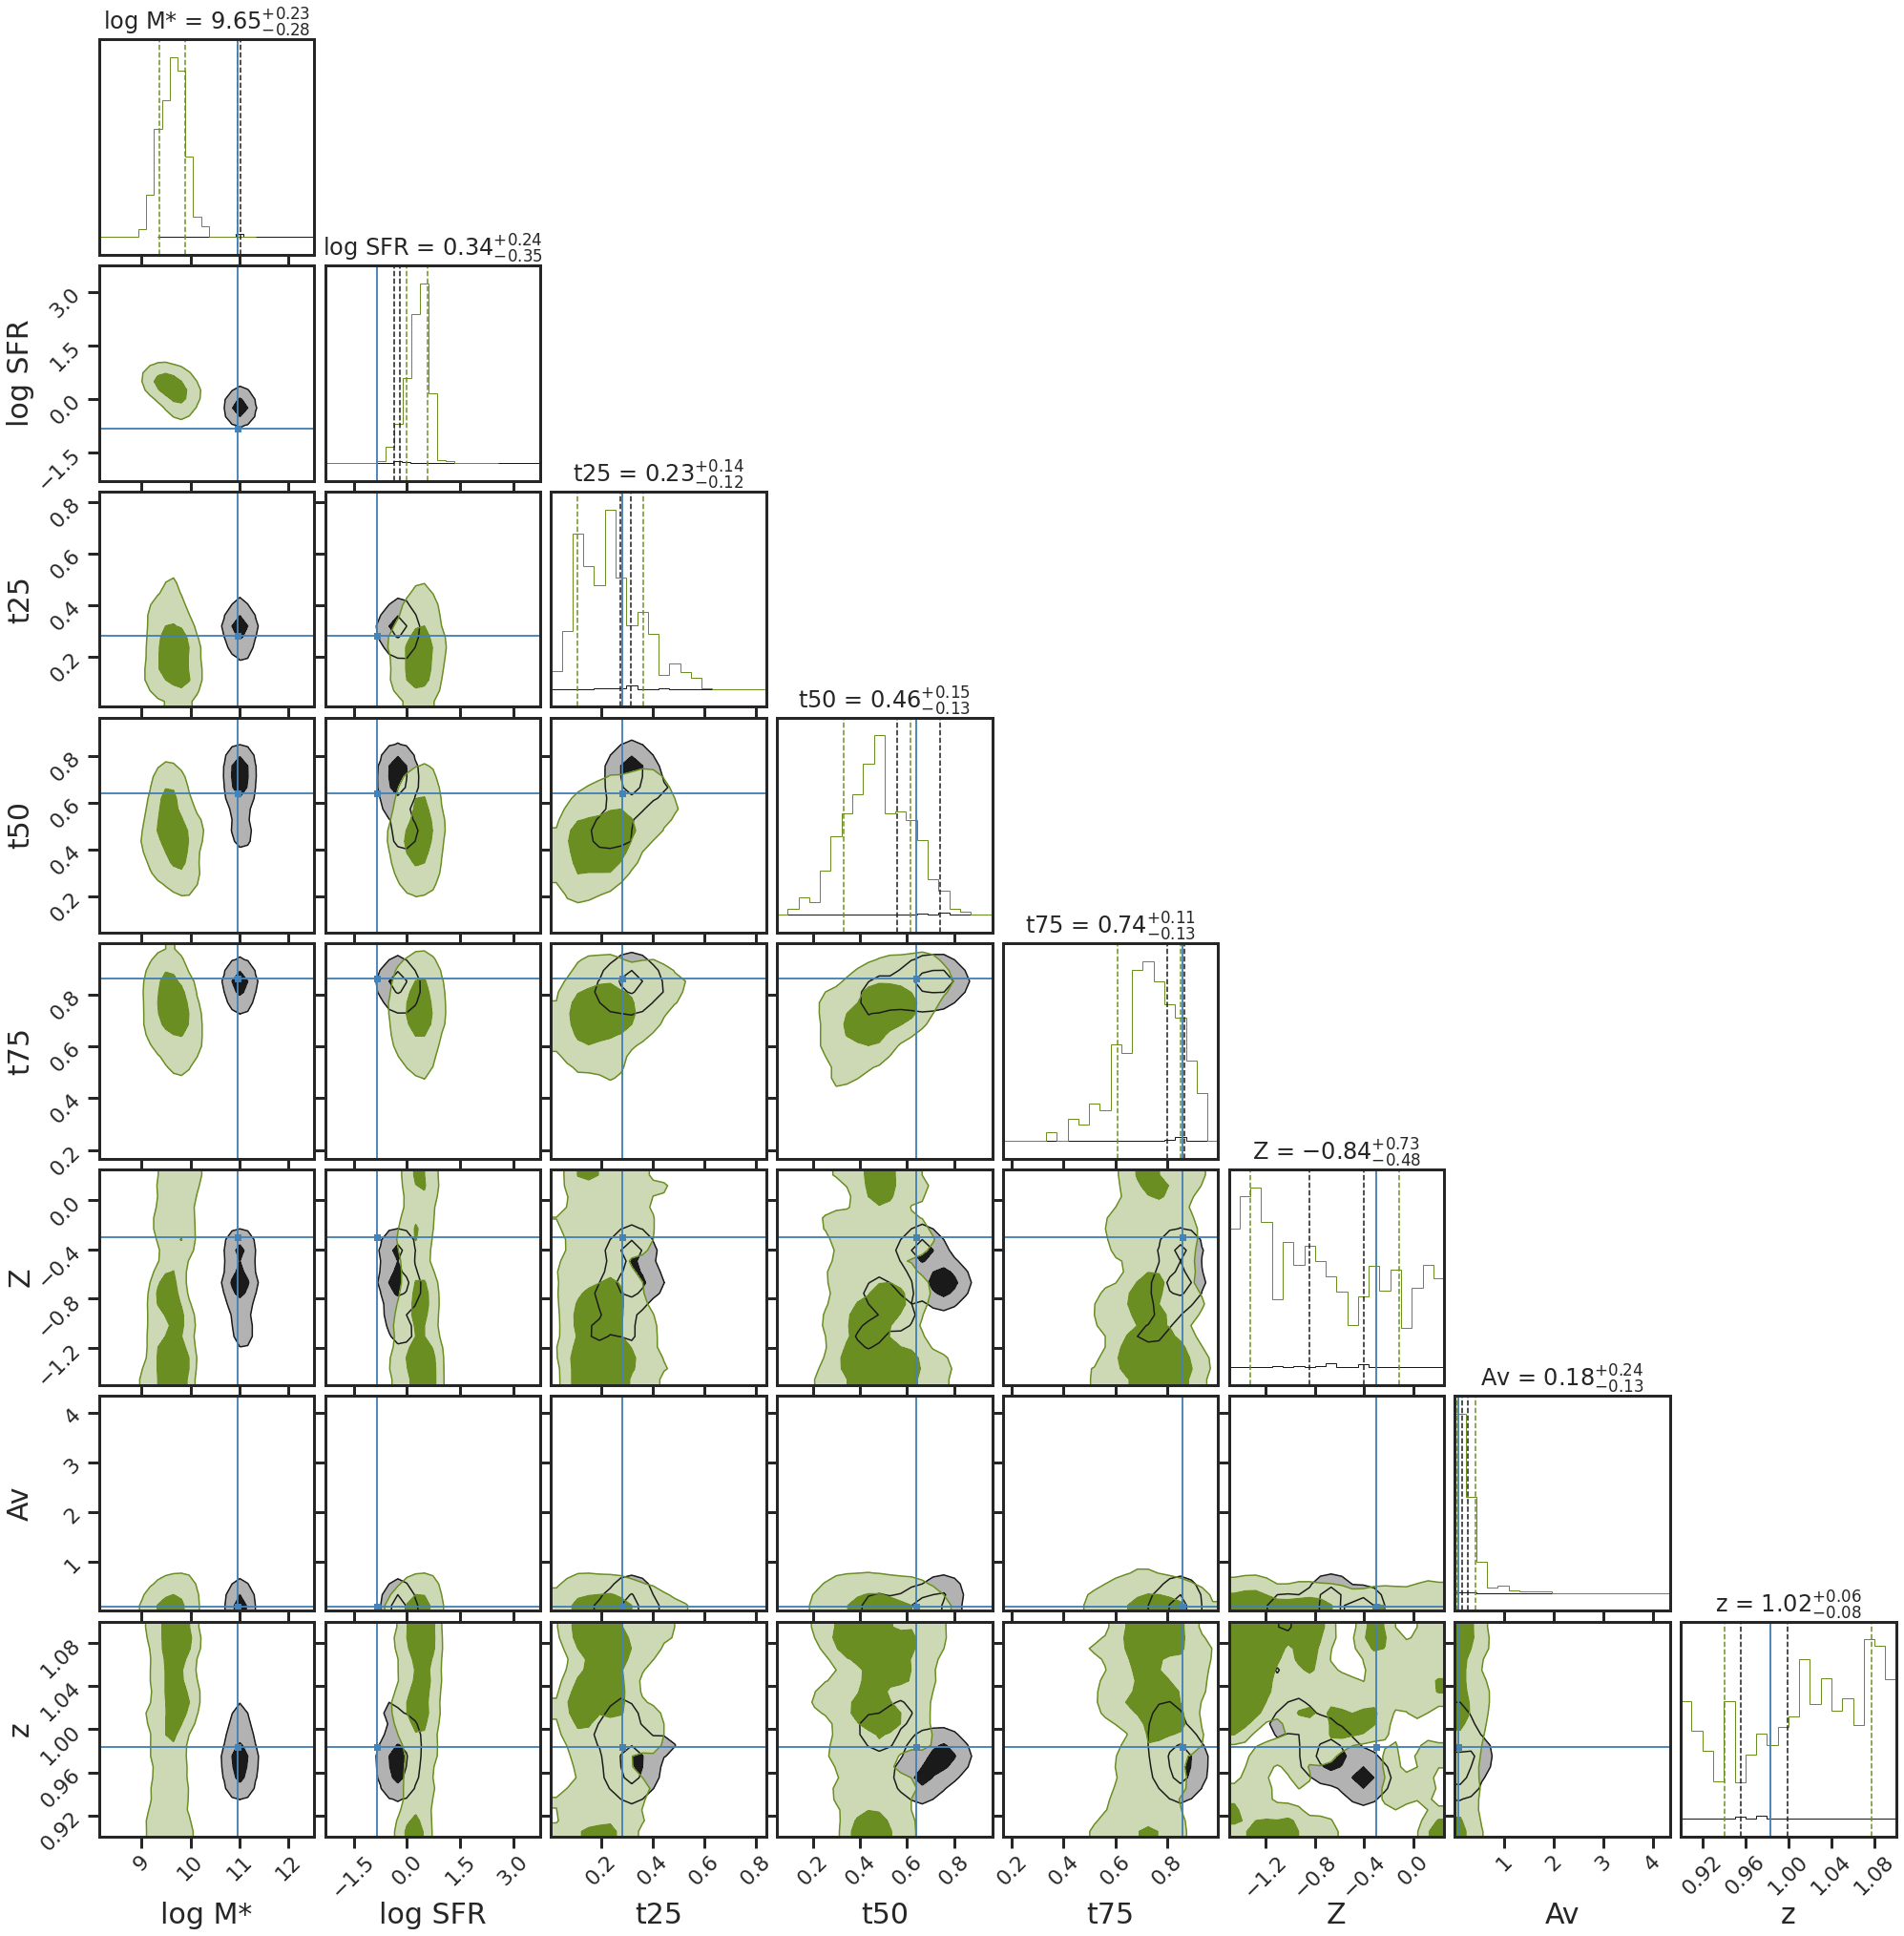

In [ ]:
fit_mask = []
obs_sed = db.makespec(specdetails, priors, db.mocksp, db.cosmo,
                                filter_list=filter_list,filt_dir=filt_dir,input_sfh=False)
obs_sed[fit_mask == False] = np.nan
obs_err = obs_sed / snr

# pass the atlas and the observed SED + uncertainties into the fitter,
sedfit = db.SedFit(obs_sed, obs_err, atlas, fit_mask=fit_mask)
sedfit.evaluate_likelihood()
sedfit.evaluate_posterior_percentiles()

fig = db.plot_posteriors(sedfit.chi2_array, sedfit.norm_fac, sedfit.sed, sedfit.atlas, truths = sed_truths, scale_hist=True)

#-------------------------------------------------------------

fit_mask = filtset_uv

obs_sed = db.makespec(specdetails, priors, db.mocksp, db.cosmo,
                                filter_list=filter_list,filt_dir=filt_dir,input_sfh=False)
obs_sed[fit_mask == False] = np.nan
obs_err = obs_sed / snr

# pass the atlas and the observed SED + uncertainties into the fitter,
sedfit = db.SedFit(obs_sed, obs_err, atlas, fit_mask=fit_mask)
sedfit.evaluate_likelihood()
sedfit.evaluate_posterior_percentiles()

fig = db.plot_posteriors(sedfit.chi2_array, sedfit.norm_fac, sedfit.sed, sedfit.atlas, truths = sed_truths, fig = fig, scale_hist=True, color='olivedrab')

#-------------------------------------------------------------

# tempy = plt.ylim()
# plt.text(0.42,tempy[1]*7,'# filters: %.0f' %(filti+1), fontsize=50,fontweight='bold')
# plt.savefig('figures/wavcov_comparison_test.png',bbox_inches='tight')
# plt.close()
plt.show()

# 4. Some actual observations - CANDELS/GOODS-South

In [ ]:
goodss_cat = np.genfromtxt('hlsp_candels_hst_wfc3_goodss-tot-multiband_f160w_v1-1photom_cat.txt')

print('Catalog shape:',goodss_cat.shape)

goodss_id = goodss_cat[0:,0]
goodss_RA = goodss_cat[0:,2]
goodss_DEC = goodss_cat[0:,3]
goodss_f160_lim_mag = goodss_cat[0:,4]
goodss_sextractor_flags = goodss_cat[0:,5]
goodss_class_star = goodss_cat[0:,6]

goodss_seds = goodss_cat[0:,np.arange(7,57,3)]
goodss_err = goodss_cat[0:,np.arange(8,58,3)]
goodss_weights = goodss_cat[0:,np.arange(9,59,3)]

goodss_hot_flag = goodss_cat[0:,71]

print('SEDs, err shape:',goodss_seds.shape, goodss_err.shape)

goodss_zcat = np.genfromtxt('zcat_GOODSS_v2.0.cat')

goodss_zcat_id = goodss_zcat[0:,1]
goodss_zcat_RA = goodss_zcat[0:,2]
goodss_zcat_DEC = goodss_zcat[0:,3]

goodss_zbest = goodss_zcat[0:,4]
goodss_zspec = goodss_zcat[0:,6]

print('zbest shape:',goodss_zbest.shape)

Catalog shape: (34930, 73)
SEDs, err shape: (34930, 17) (34930, 17)
zbest shape: (34930,)


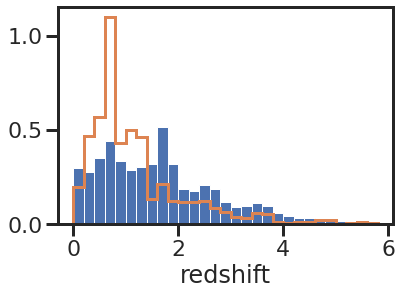

In [ ]:
plt.hist(goodss_zbest, np.arange(0,6,0.2), density=True)
plt.hist(goodss_zspec[goodss_zspec>0], np.arange(0,6,0.2), density=True, histtype='step',lw=3)
plt.xlabel('redshift')
plt.show()

In [ ]:
# atlas = db.load_atlas(fname = 'test_goodss_atlas', path='atlas/', N_pregrid = 100000, N_param = priors.Nparam)
atlas_seds = atlas['sed']
for i in range(len(atlas['norm'])):
    atlas_seds[i,0:] = atlas_seds[i,0:]*atlas['norm'][i]

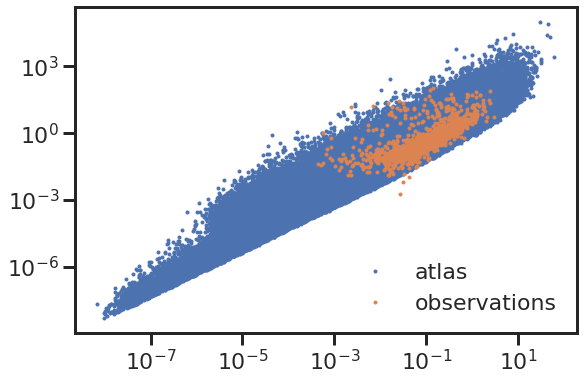

In [ ]:
zval = 1.0
mask = (np.abs(goodss_zbest - zval) < 0.1)
goodss_z1_seds = goodss_seds.copy()[mask, 0:]
goodss_z1_errs = goodss_err.copy()[mask, 0:]


band_1 = 0
band_2 = 12
plt.figure(figsize=(9,6))
plt.plot(atlas_seds[0:,band_1],atlas_seds[0:,band_2],'.',label='atlas')
plt.plot(goodss_z1_seds[0:,band_1],goodss_z1_seds[0:,band_2],'.',label='observations')
plt.xscale('log'); plt.yscale('log')
plt.legend(edgecolor='w',loc=4,)
plt.show()

# 5. Going further - Degeneracies, Sampling, Information Content and ML methods? 

Questions:

1. **Are age-dust-metallicity degeneracies as bad as they used to be? What helps break the impasse?** Discussion points: Wavelength range, better resolution, moving beyond age, correlated priors...
2. **Are we fundamentally limited in the amount of information we can get from an SED?**
3. Are SED fitting methods as efficient as possible? In terms of modeling, sampling, and individual/population-level inference?
4. What do we need to include for better forward modeling from simulations?
5. Are there physically motivated constraints on priors we should be using?
6. Can we used SED modeling for survey design?
7. What additional challenges do resolved SED fitting problems pose?
8. Is it double dipping to infer priors from data or calibrate zeropoints?
9. What new astrophysics should we be thinking of for future SED fitting codes?


Hack ideas:
- Reformulate the basic fitting example shown here in terms of simulation based inference ([ChangHoon Hahn's tutorial](https://colab.research.google.com/github/changhoonhahn/galevo23-tutorials/blob/main/week-3/sbi_tutorial.ipynb) from yesterday is an excellent starting point!)
- Reformulate the basic example using [autodiff](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html).
- Quantify and add aleatoric and epistemic uncertainties to the simple likelihood we used following [Aritra Ghosh's tutorial](https://github.com/aritraghsh09/pop_py_prog/blob/master/ml/ml_uncertainties/robust_uncertainities.ipynb).
- Build physical models for metallicity histories (e.g. from a galaxy's SFH)
- Consider constructing correlated priors and exploring their effects on the fits.

Resolved observations: low S/N fits or tesselate? Why?

In [ ]:
!pip install sbi -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 KB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


SBI following ChangHoon's tutorial:

In [ ]:
import torch
from sbi import utils as Ut
from sbi import inference as Inference

In [ ]:
lower_bounds = torch.tensor([8., -1., 0.5, 0.05, -0.5, 0.])
upper_bounds = torch.tensor([10., 1, 0.99, 0.15, 0.5, 1.0])
bounds = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device='cpu')

In [ ]:
nhidden = 128 
nblocks = 5

maf_model = Ut.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks)

In [ ]:
sfrvals = atlas['sfr'].copy()
pg_params = np.vstack([atlas['mstar'],sfrvals,atlas['sfh_tuple'][0:,3:].T,atlas['met'].ravel(),atlas['dust'].ravel(),atlas['zval'].ravel()])

corner_params = pg_params.copy()
corner_params[0,0:] += np.log10(atlas['norm'])
corner_params[1,0:] += np.log10(atlas['norm'])
corner_params = corner_params.T


In [ ]:
anpe = Inference.SNPE(prior=bounds,
                      density_estimator=maf_model,
                      device='cpu')

anpe.append_simulations(
            torch.as_tensor(corner_params.astype(np.float32)).to('cpu'),
            torch.as_tensor(atlas_seds.astype(np.float32)).to('cpu'))

# estimate p(theta|X)
p_theta_x_est = anpe.train()

 Training neural network. Epochs trained: 138

In [ ]:
qphi = anpe.build_posterior(p_theta_x_est)

(8, 100000)

In [ ]:
posterior_samples = np.array(qphi.sample((10000,), 
                            x=torch.as_tensor(np.array([sed]).astype(np.float32)).to('cpu'), 
                            show_progress_bars=False).detach().to('cpu'))

In [ ]:
corner.corner(posterior_samples, 
            labels=[r'$\log M_*$', '$z$'], 
            label_kwargs={'fontsize': 25},
            color='C1', hist_kwargs={'density': True})